<a href="https://colab.research.google.com/github/einjunge99/ETL/blob/migration-v4/CreditFactory_v3_0_(Precalificaci%C3%B3n).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
`# Copyright 2022 Google LLC
#
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
#     https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

SyntaxError: invalid syntax (<ipython-input-1-99a7dbf18236>, line 1)

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/GoogleCloudPlatform/cloud-sql-python-connector/blob/main/samples/notebooks/sqlserver_python_connector.ipynb)
# **Connect to Cloud SQL using the Cloud SQL Python Connector**


### 🔐 Authenticate to Google Cloud within Colab
Authenticate to Google Cloud as the IAM user logged into this notebook in order to access your Google Cloud Project.

In [176]:
from google.colab import auth

auth.authenticate_user()

### 🔗 Connect Your Google Cloud Project
Time to connect your Google Cloud Project to this notebook so that you can leverage Google Cloud from within Colab. 🏅 😀

In [177]:
#@markdown Please fill in the value below with your GCP project ID and then run the cell.

# Please fill in these values.
project_id = "uvg-integrador" #@param {type:"string"}

# Quick input validations.
assert project_id, "⚠️ Please provide a Google Cloud project ID"

# Configure gcloud.
!gcloud config set project {project_id}

Updated property [core/project].


### ☁ Configure Your Google Cloud Project
Configure the following in your Google Cloud Project.

1. IAM principal (user, service account, etc.) with the
[Cloud SQL Client][client-role] role.

> 🚨 The user logged into this notebook will be used as the IAM principal and will be granted the Cloud SQL Client role.

[client-role]: https://cloud.google.com/sql/docs/mysql/roles-and-permissions

In [ ]:
# grant Cloud SQL Client role to authenticated user
current_user = !gcloud auth list --filter=status:ACTIVE --format="value(account)"

!gcloud projects add-iam-policy-binding {project_id} \
  --member=user:{current_user[0]} \
  --role="roles/cloudsql.client"

Updated IAM policy for project [uvg-integrador].
bindings:
- members:
  - user:2982192200101@ingenieria.usac.edu.gt
  - user:nelsonalesandrog@gmail.com
  role: roles/cloudsql.client
- members:
  - serviceAccount:service-108581707894@compute-system.iam.gserviceaccount.com
  role: roles/compute.serviceAgent
- members:
  - serviceAccount:108581707894-compute@developer.gserviceaccount.com
  - serviceAccount:108581707894@cloudservices.gserviceaccount.com
  role: roles/editor
- members:
  - user:2982192200101@ingenieria.usac.edu.gt
  - user:mor231807@uvg.edu.gt
  - user:nelsonalesandrog@gmail.com
  role: roles/owner
etag: BwYgJ3PPpDI=
version: 1


2. Enable the [Cloud SQL Admin API][admin-api] within your project.

[admin-api]: https://console.cloud.google.com/apis/api/sqladmin.googleapis.com

In [ ]:
# enable Cloud SQL Admin API
!gcloud services enable sqladmin.googleapis.com

## 🐍 Python Connector Usage
Let's now connect to Cloud SQL using the Python Connector! 🚀 ⭐ 🐍

### 💻 **Install Code Dependencies**
It is recommended to use the Connector alongside a library that can create connection pools, such as [SQLAlchemy](https://www.sqlalchemy.org/).
This will allow for connections to remain open and be reused, reducing connection overhead and the number of connections needed

Let's `pip install` the [Cloud SQL Python Connector](https://github.com/GoogleCloudPlatform/cloud-sql-python-connector) as well as [SQLAlchemy](https://www.sqlalchemy.org/), using the below command.

In [178]:
# install dependencies
import sys
!{sys.executable} -m pip install cloud-sql-python-connector["pytds"] SQLAlchemy==2.0.7 sqlalchemy-pytds==0.3.5


## 🗄 **Connect to a SQL Server Instance**
We are now ready to connect to a SQL Server instance using the Cloud SQL Python Connector! 🐍 ⭐ ☁


Let's set some parameters that are needed to connect properly to a Cloud SQL instance:
*   `INSTANCE_CONNECTION_NAME` : The connection name to your Cloud SQL Instance, takes the form `PROJECT_ID:REGION:INSTANCE_NAME`.
*   `DB_USER` : The user that the connector will use to connect to the database.
*   `DB_PASS` : The password of the DB_USER.
*   `DB_NAME` : The name of the database on the Cloud SQL instance to connect to.

In [179]:
region = "us-central1" #@param {type:"string"}
instance_name = "s7crdt" #@param {type:"string"}

# initialize parameters
INSTANCE_CONNECTION_NAME = f"{project_id}:{region}:{instance_name}" # i.e demo-project:us-central1:demo-instance
print(f"Your instance connection name is: {INSTANCE_CONNECTION_NAME}")
DB_USER = "sqlserver"
DB_PASS = "MaquinaUVG."
DB_NAME = "s7credit"

Your instance connection name is: uvg-integrador:us-central1:s7crdt


In [180]:
DB_USER = 's7bi03'
DB_PASS = '$7B!yQ5HUqW11k'
DB_HOST = '192.250.238.26'  # IP address of your SQL Server instance
DB_PORT = '1434'            # Default port for SQL Server
DB_NAME = 'S7SGB'

### ✅ **Basic Usage**
To connect to Cloud SQL using the connector, inititalize a `Connector` object and call its `connect` method with the proper input parameters.

The `connect` method takes in the parameters we previously defined, as well as a few additional parameters such as:
*   `driver`: The name of the database driver to connect with.
*   `ip_type` (optional): The IP type (public or private)  used to connect. IP types can be either `IPTypes.PUBLIC` or `IPTypes.PRIVATE`. ([Example](#scrollTo=yjAPpIDdRfu2))
*   `enable_iam_auth`: (optional) Boolean enabling IAM based authentication. (Postgres and MySQL only)

Let's show an example! 🤘 🙌

In [ ]:
from google.cloud.sql.connector import Connector, IPTypes
import sqlalchemy
from sqlalchemy import Column, Float, Integer, String, Table

# initialize Connector object
connector = Connector()

# function to return the database connection object
def getconn():
    conn = connector.connect(
        INSTANCE_CONNECTION_NAME,
        "pytds",
        user=DB_USER,
        password=DB_PASS,
        db=DB_NAME,
    )
    return conn

# create connection pool with 'creator' argument to our connection object function
pool = sqlalchemy.create_engine(
    "mssql+pytds://",
    creator=getconn,
    connect_args={"charset": "utf-8"}
)

<ipython-input-5-6798d6ff0d28>:20: SADeprecationWarning: The dbapi() classmethod on dialect classes has been renamed to import_dbapi().  Implement an import_dbapi() classmethod directly on class <class 'sqlalchemy_pytds.dialect.MSDialect_pytds'> to remove this warning; the old .dbapi() classmethod may be maintained for backwards compatibility.
  pool = sqlalchemy.create_engine(


To use this connector with SQLAlchemy, we use the `creator` argument for `sqlalchemy.create_engine`

Now that we have established a connection pool, let's write a query! 🎉 📝

In [181]:
import pandas as pd
from sqlalchemy import text

In [182]:
connection_string = f"mssql+pytds://{DB_USER}:{DB_PASS}@{DB_HOST}:{DB_PORT}/{DB_NAME}"

# Create the SQLAlchemy engine
pool = create_engine(connection_string)

<ipython-input-182-7bd743e1f4d0>:4: SADeprecationWarning: The dbapi() classmethod on dialect classes has been renamed to import_dbapi().  Implement an import_dbapi() classmethod directly on class <class 'sqlalchemy_pytds.dialect.MSDialect_pytds'> to remove this warning; the old .dbapi() classmethod may be maintained for backwards compatibility.
  pool = create_engine(connection_string)


# ETL

## Text Analytics

In [ ]:
with pool.connect() as db_conn:
    # Use pd.read_sql to directly load the query results into a DataFrame
    raw_wf_accion_etapa = pd.read_sql('select acc.Descripcion from dbo.S7N_WF_ETAPA_INCIDENTE_HISTORIAL_TIEMPO_EVENTO hist, dbo.WF_Accion_etapa  acc where acc.Etapa_incidente  = hist.IdEtapaIncidente  and hist.IdTipoEvento = 7', db_conn)
    #raw_wf_accion_etapa = pd.read_sql(text("select * from dbo.WF_Accion_etapa"), db_conn)

InterfaceError: (pytds.tds_base.InterfaceError) Invalid TDS marker: 0(0)
(Background on this error at: https://sqlalche.me/e/20/rvf5)

## Dimensionales

In [ ]:
gold_dimensional = pd.DataFrame({
    'id_dimensional': [1, 2, 3],
    'nombre': ['Minutos',  'Horas', 'Días'],
    'valor': [1, 60, 1440]
}
)

## Empleado

In [ ]:
with pool.connect() as db_conn:
    # Use pd.read_sql to directly load the query results into a DataFrame
    raw_tc_epl_empleado = pd.read_sql(text("select * from dbo.TC_EPL_EMPLEADO"), db_conn)

In [ ]:
raw_tc_epl_empleado.head()

,EMPLEADO,EXTENSION,ACTIVO,PUE_PUESTO,EXPERIENCIA_CC,AAT_ATENCION,COMENTARIO,SUELDO,TIPO_SALARIO,TUR_TURNO,Empresa,email,GrupoTrabajo,NoAplicaCarga,Perfil
0,0,None,A,0,False,0,None,6.0,None,0,1,empleado_0_correo@sigma7uat.com,NaN,None,0
1,1,None,A,0,False,20017,PM/QA,6000.0,M,1,1,empleado_1_correo@sigma7uat.com,NaN,None,0
2,2,,A,0,False,0,None,0.0,None,0,1,empleado_2_correo@sigma7uat.com,NaN,None,0
3,9,,A,0,False,0,None,0.0,None,0,1,empleado_9_correo@sigma7uat.com,NaN,None,0
4,24,None,A,0,False,20017,None,0.0,H,0,1,empleado_24_correo@sigma7uat.com,NaN,None,0


In [ ]:
tc_epl_empleado = raw_tc_epl_empleado[
    [
     'EMPLEADO',
     'email',
     'GrupoTrabajo'
     ]
    ].rename(columns={
    'EMPLEADO': 'id_empleado',
    'email': 'email',
})


## Tiempo Evento

In [ ]:
with pool.connect() as db_conn:
    # Use pd.read_sql to directly load the query results into a DataFrame
    raw_wf_tipo_evento = pd.read_sql(text("SELECT * FROM dbo.S7N_WF_TIPO_EVENTO_TIEMPO"), db_conn)

# Show the DataFrame
print(raw_wf_tipo_evento)

   Id        Nombre
0   1      CREACIÓN
1   2   CANCELACIÓN
2   3  FINALIZACIÓN
3   4        INICIO
4   5    ASIGNACIÓN
5   6     REPROCESO
6   7       RECHAZO
7   8  REACTIVACIÓN
8   9      ATENCIÓN


In [ ]:
silver_wf_tipo_evento = raw_wf_tipo_evento[[
    'Id',
    'Nombre',
    ]].rename(
    columns={
        'Id': 'id_tipo_evento',
        'Nombre': 'nombre',
    }
)

In [ ]:
gold_wf_tipo_evento = silver_wf_tipo_evento.copy(deep = True)

## Etapa Incidente Historial Tiempo Evento




In [192]:
with pool.connect() as db_conn:
    # Use pd.read_sql to directly load the query results into a DataFrame
    raw_wf_etapa_incidente_historial_tiempo_evento = pd.read_sql(text("SELECT * FROM dbo.S7N_WF_ETAPA_INCIDENTE_HISTORIAL_TIEMPO_EVENTO"), db_conn)

# Show the DataFrame
print(raw_wf_etapa_incidente_historial_tiempo_evento)

              Id           FechaRegistro      FechaActualizacion  Tiempo  \
0              1 2020-08-04 17:53:05.147 2020-08-04 17:53:07.087       0   
1              2 2020-08-04 17:53:07.087 2020-08-04 17:53:07.213       0   
2              3 2020-08-04 17:53:07.213 2020-08-04 18:25:53.517       0   
3              4 2020-08-04 18:25:53.517 2020-08-04 18:36:27.587       0   
4              5 2020-08-04 18:25:53.517                     NaT       0   
...          ...                     ...                     ...     ...   
2502180  2857887 2024-08-05 09:52:37.170 2024-08-05 09:52:41.403       0   
2502181  2857889 2024-08-05 09:52:41.403 2024-08-05 09:52:41.500       0   
2502182  2857890 2024-08-05 09:52:41.500 2024-08-05 09:52:46.000       0   
2502183  2857891 2024-08-05 09:52:46.000 2024-08-05 09:52:46.090       0   
2502184  2857892 2024-08-05 09:52:46.090                     NaT       0   

         TiempoCorrido  EstadoAnterior  EstadoActual  IdEtapaIncidente  \
0            

In [ ]:
raw_wf_etapa_incidente_historial_tiempo_evento.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 933192 entries, 0 to 933191
Data columns (total 11 columns):
 #   Column              Non-Null Count   Dtype         
---  ------              --------------   -----         
 0   Id                  933192 non-null  int64         
 1   FechaRegistro       933192 non-null  datetime64[ns]
 2   FechaActualizacion  729511 non-null  datetime64[ns]
 3   Tiempo              933192 non-null  int64         
 4   TiempoCorrido       933192 non-null  int64         
 5   EstadoAnterior      701070 non-null  float64       
 6   EstadoActual        933192 non-null  int64         
 7   IdEtapaIncidente    933192 non-null  int64         
 8   IdTipoEvento        933192 non-null  int64         
 9   IdEmpleadoOpera     565644 non-null  float64       
 10  IdEmpleadoAsignado  917746 non-null  float64       
dtypes: datetime64[ns](2), float64(3), int64(6)
memory usage: 78.3 MB


In [205]:
silver_wf_etapa_incidente_historial_tiempo_evento = raw_wf_etapa_incidente_historial_tiempo_evento[[
    'Id',
    'FechaRegistro',
    'FechaActualizacion',
    'Tiempo',
    'IdEtapaIncidente',
    'IdTipoEvento',
    'IdEmpleadoOpera',
    'IdEmpleadoAsignado',
    'EstadoActual'
    ]].rename(
    columns={
        'Id': 'id_etapa_incidente_historial_tiempo_evento',
        'FechaRegistro': 'fecha_registro',
        'FechaActualizacion': 'fecha_actualizacion',
        'Tiempo': 'tiempo',
        'IdEtapaIncidente': 'id_etapa_incidente',
        'IdTipoEvento': 'id_tipo_evento',
        'IdEmpleadoOpera': 'id_empleado_opera',
        'IdEmpleadoAsignado': 'id_empleado_asignado',
        'EstadoActual': 'estado_actual'
        }
)

In [206]:
silver_wf_etapa_incidente_historial_tiempo_evento['id_empleado_opera'] = silver_wf_etapa_incidente_historial_tiempo_evento['id_empleado_opera'].astype('Int64')
silver_wf_etapa_incidente_historial_tiempo_evento['id_empleado_asignado'] = silver_wf_etapa_incidente_historial_tiempo_evento['id_empleado_asignado'].astype('Int64')

In [207]:
gold_wf_etapa_incidente_historial_tiempo_evento = silver_wf_etapa_incidente_historial_tiempo_evento.copy(deep = True)

In [208]:
gold_wf_etapa_incidente_historial_tiempo_evento.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2502185 entries, 0 to 2502184
Data columns (total 9 columns):
 #   Column                                      Dtype         
---  ------                                      -----         
 0   id_etapa_incidente_historial_tiempo_evento  int64         
 1   fecha_registro                              datetime64[ns]
 2   fecha_actualizacion                         datetime64[ns]
 3   tiempo                                      int64         
 4   id_etapa_incidente                          int64         
 5   id_tipo_evento                              int64         
 6   id_empleado_opera                           Int64         
 7   id_empleado_asignado                        Int64         
 8   estado_actual                               int64         
dtypes: Int64(2), datetime64[ns](2), int64(5)
memory usage: 176.6 MB


## Proceso

In [ ]:
with pool.connect() as db_conn:
    # Use pd.read_sql to directly load the query results into a DataFrame
    raw_wf_proceso = pd.read_sql(text("SELECT * FROM dbo.WF_Proceso"), db_conn)

In [ ]:
print(raw_wf_proceso.isnull().sum())
print(raw_wf_proceso.info())

Proceso                      0
Nombre                       0
Tiempo_estimado              0
Muestra_QA                   0
Clase_proceso                0
Unidad_medida                0
Max_frecuencia_diaria        0
Dia_antes_alarma             0
Empleado_creacion            0
Fecha_creacion               0
Empleado_modifica            0
Fecha_modifica               0
Tipo_proceso                 0
Estado                       0
Porcentaje_holgura           0
Descripcion                  0
Empleado_encargado           2
asignacion_etapa_inicial     0
Tipo_Fin_Etapa_Inicial       2
Empresa_Retipifica           2
Unidad_Negocio_Retipifica    2
Self_Service                 0
Origen                       2
Gestion_Externa              0
Cantidad_Incidentes          0
Requiere_Meta                0
EnvioMail                    0
NotificacionQueja            2
NotificacionCierre           0
NotificacionApertura         0
IncluyeReporteSI             2
Tipologia                    2
SubTipol

In [ ]:
silver_wf_proceso = raw_wf_proceso[[
    'Proceso', 'Nombre'
]].rename(columns={
    'Proceso': 'id_proceso',
    'Nombre': 'nombre_proceso',
})

In [ ]:
gold_wf_proceso = silver_wf_proceso.copy(deep=True)

## Etapa

In [ ]:
with pool.connect() as db_conn:
    # Use pd.read_sql to directly load the query results into a DataFrame
    raw_wf_etapa = pd.read_sql(text("SELECT * FROM dbo.WF_Etapa"), db_conn)

In [ ]:
silver_wf_etapa = raw_wf_etapa[[
    'Etapa', 'Proceso', 'Nombre', 'Tiempo_estimado', 'Unidad_medida'
]].rename(columns={
    'Etapa': 'id_etapa',
    'Proceso': 'id_proceso',
    'Nombre': 'nombre_etapa',
    'Tiempo_estimado': 'tiempo_estimado_etapa',
    'Unidad_medida': 'unidad_medida_etapa'
})


In [ ]:
gold_wf_etapa = silver_wf_etapa.copy(deep=True)

In [ ]:
gold_wf_etapa.head()

,id_etapa,id_proceso,nombre_etapa,tiempo_estimado_etapa,unidad_medida_etapa
0,1,1,Solicitud ...,2.0,2
1,2,1,Aprobacion ...,2.0,1
2,3,1,Aprobacion I ...,2.0,1
3,4,1,Aprobación II ...,2.0,1
4,5,1,Aprobación III ...,2.0,1


## Incidente

In [ ]:
with pool.connect() as db_conn:
    # Use pd.read_sql to directly load the query results into a DataFrame
    raw_wf_incidente = pd.read_sql(text("SELECT * FROM dbo.WF_Incidente"), db_conn)

# Show the DataFrame
print(raw_wf_incidente)

       Incidente      Fecha_hora_entrada  Persona  Cliente  Tipo_cliente  \
0              1 2020-10-29 15:53:02.600        1        2             2   
1              2 2020-10-30 10:48:30.463        1        2             2   
2              3 2020-11-11 14:48:18.163        1        2             2   
3              4 2020-11-12 15:55:58.260        1        2             2   
4              5 2020-11-12 15:58:41.983        1        2             2   
...          ...                     ...      ...      ...           ...   
16684      19693 2024-08-12 16:57:20.360    15038    15040             2   
16685      19694 2024-08-12 17:45:36.003    18068    18070             2   
16686      19695 2024-08-12 18:09:30.820    17693    17695             2   
16687      19696 2024-08-12 18:25:25.707    17693    17695             2   
16688      19697 2024-08-12 18:49:27.870    18069    18071             2   

      Empleado_asigna  Estado            Fecha_estado  Proceso  Empleado_crea  \
0     

### Análisis exploratorio

In [ ]:
# General overview of the DataFrame
print(raw_wf_incidente.info())

# Display the first few rows of the DataFrame
print(raw_wf_incidente.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 36298 entries, 0 to 36297
Data columns (total 26 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   Incidente            36298 non-null  int64         
 1   Fecha_hora_entrada   36298 non-null  datetime64[ns]
 2   Persona              36298 non-null  int64         
 3   Cliente              36298 non-null  int64         
 4   Tipo_cliente         36298 non-null  int64         
 5   Empleado_asigna      0 non-null      object        
 6   Estado               36298 non-null  int64         
 7   Fecha_estado         36298 non-null  datetime64[ns]
 8   Proceso              36298 non-null  int64         
 9   Empleado_crea        36298 non-null  int64         
 10  Incidente_anterior   2 non-null      float64       
 11  Area_atencion        36298 non-null  int64         
 12  Empresa_crea         36298 non-null  int64         
 13  Descripcion          36298 non-

In [ ]:
# Summary statistics of numerical columns
print(raw_wf_incidente.describe())

# Summary statistics of non-numerical columns
print(raw_wf_incidente.describe(include=['object']))


          Incidente             Fecha_hora_entrada        Persona  \
count  36298.000000                          36298   36298.000000   
mean   18710.737809  2022-03-31 23:48:35.299861760   55984.922337   
min        1.000000     2019-09-03 11:24:15.087000   10360.000000   
25%     9097.250000  2021-06-18 14:32:37.454999808   34447.500000   
50%    19180.500000  2022-05-29 07:43:55.312999936   54285.500000   
75%    28262.750000  2023-04-05 15:54:30.776999936   75260.250000   
max    37347.000000     2023-12-19 17:09:53.103000  108972.000000   
std    10924.407649                            NaN   25595.810229   

             Cliente  Tipo_cliente        Estado  \
count   36298.000000  36298.000000  36298.000000   
mean    55802.531847      2.118078      2.301559   
min     10340.000000      2.000000      1.000000   
25%     34251.500000      2.000000      2.000000   
50%     54090.500000      2.000000      2.000000   
75%     75065.250000      2.000000      3.000000   
max    108777.

In [ ]:
# Check for missing values
print(raw_wf_incidente.isnull().sum())

NameError: name 'wf_incidente' is not defined

array([[<Axes: title={'center': 'Incidente'}>,
        <Axes: title={'center': 'Fecha_hora_entrada'}>,
        <Axes: title={'center': 'Persona'}>,
        <Axes: title={'center': 'Cliente'}>],
       [<Axes: title={'center': 'Tipo_cliente'}>,
        <Axes: title={'center': 'Estado'}>,
        <Axes: title={'center': 'Fecha_estado'}>,
        <Axes: title={'center': 'Proceso'}>],
       [<Axes: title={'center': 'Empleado_crea'}>,
        <Axes: title={'center': 'Incidente_anterior'}>,
        <Axes: title={'center': 'Area_atencion'}>,
        <Axes: title={'center': 'Empresa_crea'}>],
       [<Axes: title={'center': 'GrupoTrabajoEpl'}>,
        <Axes: title={'center': 'Gestion_Externa'}>,
        <Axes: title={'center': 'Prioridad'}>, <Axes: >]], dtype=object)

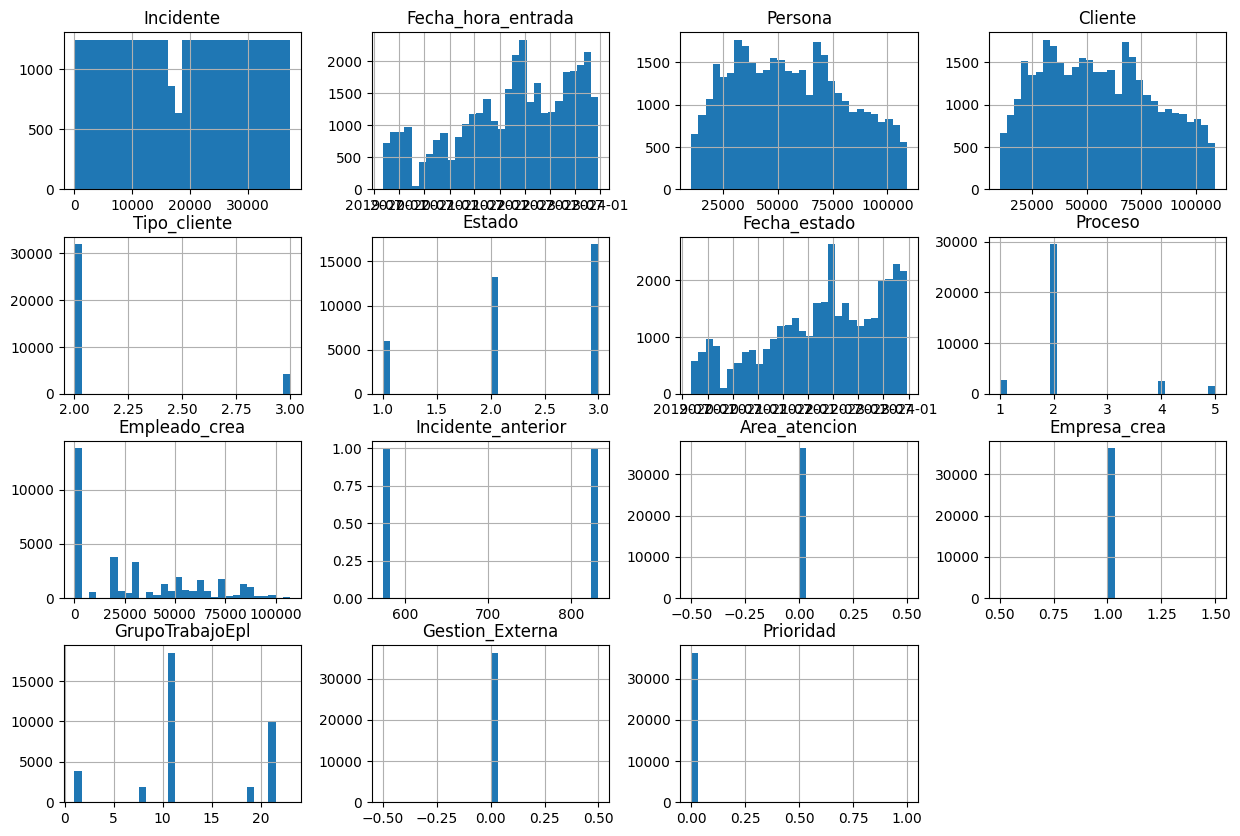

In [ ]:
# Plotting histograms for all numerical columns
raw_wf_incidente.hist(bins=30, figsize=(15, 10))


### Limpieza

In [ ]:
silver_wf_incidente = raw_wf_incidente[[
    'Incidente',
    'Fecha_hora_entrada',
    'Persona',
    'Cliente',
    'Estado',
    'Proceso',
    'Empleado_crea',
    'Descripcion',
    ]].rename(
    columns={
        'Incidente': 'id_incidente',
        'Fecha_hora_entrada': 'fecha_creacion',
        'Persona': 'id_persona',
        'Cliente': 'id_cliente',
        'Estado': 'estado',
        'Proceso': 'id_proceso',
        'Empleado_crea': 'id_empleado_crea',
        'Descripcion': 'descripcion'
        }
)

In [ ]:
estado_mapping = {1: 'En proceso', 2: 'Cancelado', 3: 'Finalizado'}

In [ ]:
silver_wf_incidente['estado'] = silver_wf_incidente['estado'].map(estado_mapping).fillna('Desconocido')

In [ ]:
silver_wf_incidente

,id_incidente,fecha_creacion,id_persona,id_cliente,estado,id_proceso,id_empleado_crea,descripcion
0,1,2019-09-03 11:24:15.087,19079,19026,Cancelado,2,0,Incidente creado desde el cotizador asociado a...
1,2,2019-09-03 16:29:25.830,20460,20283,Finalizado,1,2,Incidente creado desde el cotizador asociado a...
2,3,2019-09-03 17:08:53.837,18488,18446,Cancelado,4,2,Incidente creado desde el cotizador asociado a...
3,4,2019-09-04 12:32:44.307,20466,20289,Finalizado,2,29,Incidente creado desde el cotizador asociado a...
4,5,2019-09-04 12:47:23.687,20470,20293,Finalizado,2,29,Incidente creado desde el cotizador asociado a...
...,...,...,...,...,...,...,...,...
36293,37343,2023-12-19 16:10:12.087,100138,99943,En proceso,2,63662,Incidente creado desde el cotizador asociado a...
36294,37344,2023-12-19 16:36:52.713,108972,108777,En proceso,1,30429,Incidente creado desde el cotizador asociado a...
36295,37345,2023-12-19 16:40:30.323,108947,108752,En proceso,2,71752,Incidente creado desde el cotizador asociado a...
36296,37346,2023-12-19 16:59:31.110,108892,108697,En proceso,2,85,Incidente creado desde el cotizador asociado a...


In [ ]:
print(silver_wf_incidente.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 36298 entries, 0 to 36297
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   id_incidente      36298 non-null  int64         
 1   fecha_creacion    36298 non-null  datetime64[ns]
 2   id_persona        36298 non-null  int64         
 3   id_cliente        36298 non-null  int64         
 4   estado            36298 non-null  object        
 5   id_proceso        36298 non-null  int64         
 6   id_empleado_crea  36298 non-null  int64         
 7   descripcion       36298 non-null  object        
dtypes: datetime64[ns](1), int64(5), object(2)
memory usage: 2.2+ MB
None


In [ ]:
# Realizar el merge entre los dos DataFrames
gold_wf_incidente =  silver_wf_incidente.copy(deep=True)

In [ ]:
print(gold_wf_incidente.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 36298 entries, 0 to 36297
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   id_incidente      36298 non-null  int64         
 1   fecha_creacion    36298 non-null  datetime64[ns]
 2   id_persona        36298 non-null  int64         
 3   id_cliente        36298 non-null  int64         
 4   estado            36298 non-null  object        
 5   id_proceso        36298 non-null  int64         
 6   id_empleado_crea  36298 non-null  int64         
 7   descripcion       36298 non-null  object        
dtypes: datetime64[ns](1), int64(5), object(2)
memory usage: 2.2+ MB
None


## Tiempos

In [216]:
with pool.connect() as db_conn:
    # Use pd.read_sql to directly load the query results into a DataFrame
    raw_wf_etapa_incidente_historial_tiempo_evento = pd.read_sql(text("SELECT * FROM dbo.S7N_WF_ETAPA_INCIDENTE_HISTORIAL_TIEMPO_EVENTO"), db_conn)

# Show the DataFrame
print(raw_wf_etapa_incidente_historial_tiempo_evento)

              Id           FechaRegistro      FechaActualizacion  Tiempo  \
0              1 2020-08-04 17:53:05.147 2020-08-04 17:53:07.087       0   
1              2 2020-08-04 17:53:07.087 2020-08-04 17:53:07.213       0   
2              3 2020-08-04 17:53:07.213 2020-08-04 18:25:53.517       0   
3              4 2020-08-04 18:25:53.517 2020-08-04 18:36:27.587       0   
4              5 2020-08-04 18:25:53.517                     NaT       0   
...          ...                     ...                     ...     ...   
2502180  2857887 2024-08-05 09:52:37.170 2024-08-05 09:52:41.403       0   
2502181  2857889 2024-08-05 09:52:41.403 2024-08-05 09:52:41.500       0   
2502182  2857890 2024-08-05 09:52:41.500 2024-08-05 09:52:46.000       0   
2502183  2857891 2024-08-05 09:52:46.000 2024-08-05 09:52:46.090       0   
2502184  2857892 2024-08-05 09:52:46.090                     NaT       0   

         TiempoCorrido  EstadoAnterior  EstadoActual  IdEtapaIncidente  \
0            

In [227]:
wf_etapa_incidente_historial_tiempo_evento = raw_wf_etapa_incidente_historial_tiempo_evento.copy(deep=True)

In [228]:
wf_etapa_incidente_historial_tiempo_evento.head()

,Id,FechaRegistro,FechaActualizacion,Tiempo,TiempoCorrido,EstadoAnterior,EstadoActual,IdEtapaIncidente,IdTipoEvento,IdEmpleadoOpera,IdEmpleadoAsignado
0,1,2020-08-04 17:53:05.147,2020-08-04 17:53:07.087,0,0,1.0,1,1,1,798.0,798.0
1,2,2020-08-04 17:53:07.087,2020-08-04 17:53:07.213,0,0,1.0,1,1,9,798.0,798.0
2,3,2020-08-04 17:53:07.213,2020-08-04 18:25:53.517,0,32,1.0,3,1,4,NaN,798.0
3,4,2020-08-04 18:25:53.517,2020-08-04 18:36:27.587,0,11,1.0,1,2,1,805.0,805.0
4,5,2020-08-04 18:25:53.517,NaT,0,0,NaN,3,1,3,NaN,798.0


In [229]:
import pandas as pd
from datetime import datetime

In [230]:
wf_etapa_incidente_historial_tiempo_evento['FechaRegistro'] = pd.to_datetime(
    wf_etapa_incidente_historial_tiempo_evento['FechaRegistro'],
    format='%Y-%m-%d %H:%M:%S.%f'
)

# Ensure FechaActualizacion is a datetime object or NaT
wf_etapa_incidente_historial_tiempo_evento['FechaActualizacion'] = pd.to_datetime(
    wf_etapa_incidente_historial_tiempo_evento['FechaActualizacion'],
    format='%Y-%m-%d %H:%M:%S',
    errors='coerce'  # Convert non-parsable dates to NaT
)

# Remove rows where FechaActualizacion is NaT (null)
wf_etapa_incidente_historial_tiempo_evento_cleaned = wf_etapa_incidente_historial_tiempo_evento.dropna(subset=['FechaActualizacion'])

# Display the filtered DataFrame
print(wf_etapa_incidente_historial_tiempo_evento)

              Id           FechaRegistro      FechaActualizacion  Tiempo  \
0              1 2020-08-04 17:53:05.147 2020-08-04 17:53:07.087       0   
1              2 2020-08-04 17:53:07.087 2020-08-04 17:53:07.213       0   
2              3 2020-08-04 17:53:07.213 2020-08-04 18:25:53.517       0   
3              4 2020-08-04 18:25:53.517 2020-08-04 18:36:27.587       0   
4              5 2020-08-04 18:25:53.517                     NaT       0   
...          ...                     ...                     ...     ...   
2502180  2857887 2024-08-05 09:52:37.170 2024-08-05 09:52:41.403       0   
2502181  2857889 2024-08-05 09:52:41.403 2024-08-05 09:52:41.500       0   
2502182  2857890 2024-08-05 09:52:41.500 2024-08-05 09:52:46.000       0   
2502183  2857891 2024-08-05 09:52:46.000 2024-08-05 09:52:46.090       0   
2502184  2857892 2024-08-05 09:52:46.090                     NaT       0   

         TiempoCorrido  EstadoAnterior  EstadoActual  IdEtapaIncidente  \
0            

In [221]:
# Convert FechaRegistro to datetime with precision for milliseconds
wf_etapa_incidente_historial_tiempo_evento['FechaRegistro'] = pd.to_datetime(
    wf_etapa_incidente_historial_tiempo_evento['FechaRegistro'], format='%Y-%m-%d %H:%M:%S.%f'
)

specific_datetime = datetime.strptime('2024-05-31 15:47:17.243', '%Y-%m-%d %H:%M:%S.%f')

# Apply the script only to rows where FechaActualizacion is null (NaN)
mask = wf_etapa_incidente_historial_tiempo_evento['FechaActualizacion'].isna()

# Calculate the difference in minutes between the current date and FechaRegistro for those records
wf_etapa_incidente_historial_tiempo_evento.loc[mask, 'Tiempo'] = (
    specific_datetime - wf_etapa_incidente_historial_tiempo_evento.loc[mask, 'FechaRegistro']
).dt.total_seconds() / 60

wf_etapa_incidente_historial_tiempo_evento['Tiempo'] = wf_etapa_incidente_historial_tiempo_evento['Tiempo'].map('{:.2f}'.format)

# Display the dataframe with the new column
print(wf_etapa_incidente_historial_tiempo_evento)

<ipython-input-221-9af91a86f92f>:12: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[2010081.39543333 2010047.7966     2010044.45233333 ...  -94683.0214
  -94683.11773333  -94685.48078333]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  wf_etapa_incidente_historial_tiempo_evento.loc[mask, 'Tiempo'] = (


              Id           FechaRegistro      FechaActualizacion      Tiempo  \
0              1 2020-08-04 17:53:05.147 2020-08-04 17:53:07.087        0.00   
1              2 2020-08-04 17:53:07.087 2020-08-04 17:53:07.213        0.00   
2              3 2020-08-04 17:53:07.213 2020-08-04 18:25:53.517        0.00   
3              4 2020-08-04 18:25:53.517 2020-08-04 18:36:27.587        0.00   
4              5 2020-08-04 18:25:53.517                     NaT  2010081.40   
...          ...                     ...                     ...         ...   
2502180  2857887 2024-08-05 09:52:37.170 2024-08-05 09:52:41.403        0.00   
2502181  2857889 2024-08-05 09:52:41.403 2024-08-05 09:52:41.500        0.00   
2502182  2857890 2024-08-05 09:52:41.500 2024-08-05 09:52:46.000        0.00   
2502183  2857891 2024-08-05 09:52:46.000 2024-08-05 09:52:46.090        0.00   
2502184  2857892 2024-08-05 09:52:46.090                     NaT   -94685.48   

         TiempoCorrido  EstadoAnterior 

To close the `Connector` object's background resources, call it's `close() ` method at the end of your code as follows:


In [231]:
tiempo_por_etapa_incidente = wf_etapa_incidente_historial_tiempo_evento.groupby('IdEtapaIncidente')['Tiempo'].sum().reset_index()
print(tiempo_por_etapa_incidente)

        IdEtapaIncidente  Tiempo
0                      1       0
1                      2       0
2                      3       0
3                      4       0
4                      5       0
...                  ...     ...
551278            787616       0
551279            787617       2
551280            787619       1
551281            787621       0
551282            787622       0

[551283 rows x 2 columns]


In [232]:
silver_tiempos = tiempo_por_etapa_incidente[[
    'IdEtapaIncidente', 'Tiempo'
]].rename(columns={
    'IdEtapaIncidente': 'id_etapa_incidente',
    'Tiempo': 'tiempo',
})

In [233]:
gold_tiempos = silver_tiempos.copy(deep=True)

## Etapa Incidente

In [244]:
with pool.connect() as db_conn:
    # Use pd.read_sql to directly load the query results into a DataFrame
    raw_wf_etapa_incidente = pd.read_sql(text("SELECT * FROM dbo.WF_Etapa_incidente"), db_conn)

In [245]:
raw_wf_etapa_incidente.head()

,Etapa_incidente,Incidente,Etapa,Fecha_hora_entrada,Estado,Empleado_asignado,Fecha_asignacion,Fecha_estado,Empleado_asigna,Estado_asignacion,Estado_aceptacion,Prioridad,fecha_sugerida_atencion,num_rechazos,estado_anterior_cancelacion,GrupoTrabajoEpl,fecha_iniciogestion,reproceso,estado_anterior,EnAtencion
0,1,1,5,2020-08-04 17:53:05.130,3,798.0,2020-08-04 17:53:05.130,2020-08-04 19:05:54.167,NaN,1,2,1,2020-08-04 17:53:05.130,1,NaN,1.0,None,0,0,False
1,2,1,6,2020-08-04 18:25:53.517,3,805.0,2020-08-04 18:25:53.517,2020-08-04 19:21:00.633,NaN,1,2,0,2020-08-04 17:53:00.000,0,NaN,2.0,None,0,2,False
2,3,2,1,2020-08-04 18:34:19.050,3,798.0,2020-08-04 18:34:19.050,2020-08-04 19:16:38.847,NaN,1,2,1,2020-08-04 18:34:19.050,1,NaN,1.0,None,0,0,False
3,4,2,2,2020-08-04 19:02:50.090,3,805.0,2020-08-04 19:02:50.090,2020-08-04 19:31:00.180,NaN,1,2,0,2020-08-04 18:34:00.000,0,NaN,2.0,None,0,2,False
4,5,1,7,2020-08-04 19:21:00.633,3,805.0,2020-08-04 19:21:00.633,2020-08-04 19:21:02.917,NaN,1,1,0,2020-08-04 19:10:00.000,0,NaN,2.0,None,0,0,False


array([[<Axes: title={'center': 'Etapa_incidente'}>,
        <Axes: title={'center': 'Incidente'}>,
        <Axes: title={'center': 'Etapa'}>,
        <Axes: title={'center': 'Fecha_hora_entrada'}>],
       [<Axes: title={'center': 'Estado'}>,
        <Axes: title={'center': 'Empleado_asignado'}>,
        <Axes: title={'center': 'Fecha_asignacion'}>,
        <Axes: title={'center': 'Fecha_estado'}>],
       [<Axes: title={'center': 'Empleado_asigna'}>,
        <Axes: title={'center': 'Estado_asignacion'}>,
        <Axes: title={'center': 'Estado_aceptacion'}>,
        <Axes: title={'center': 'Prioridad'}>],
       [<Axes: title={'center': 'fecha_sugerida_atencion'}>,
        <Axes: title={'center': 'num_rechazos'}>,
        <Axes: title={'center': 'estado_anterior_cancelacion'}>,
        <Axes: title={'center': 'GrupoTrabajoEpl'}>],
       [<Axes: title={'center': 'reproceso'}>,
        <Axes: title={'center': 'estado_anterior'}>, <Axes: >, <Axes: >]],
      dtype=object)

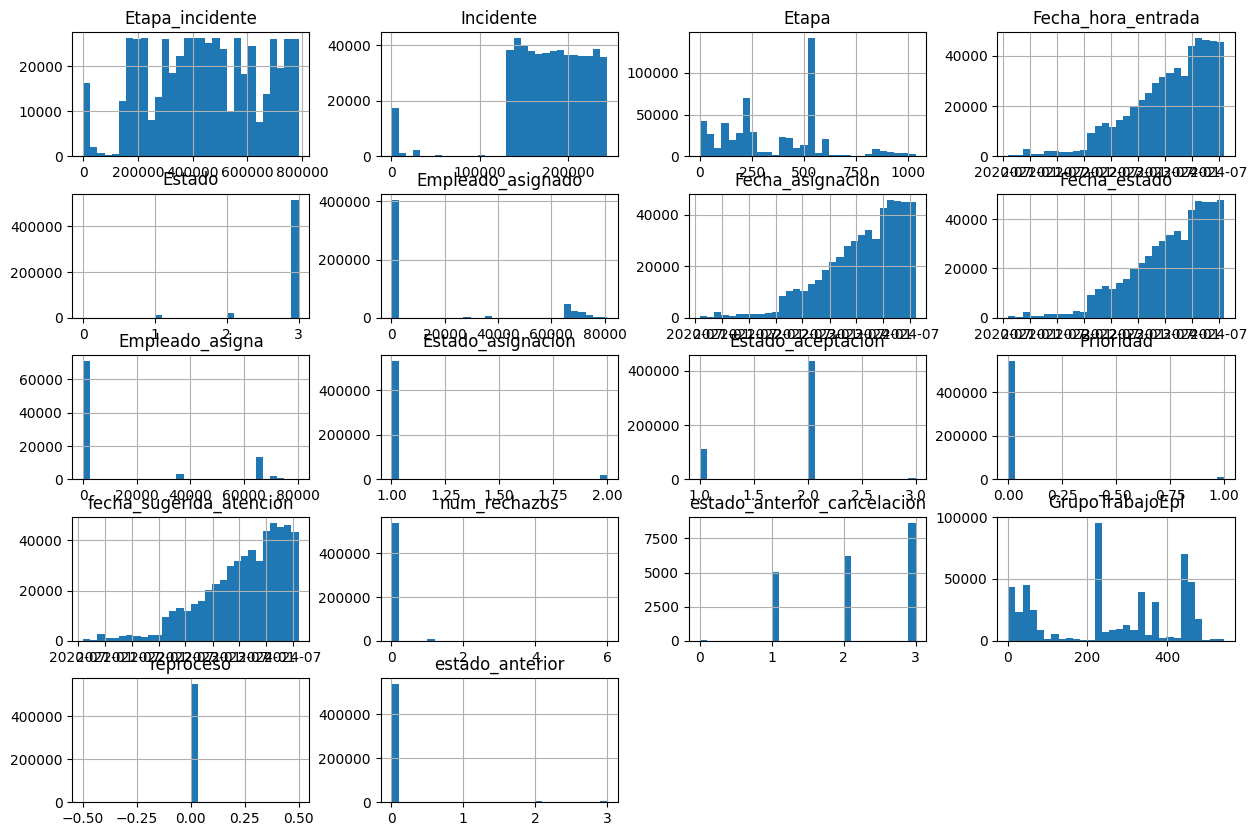

In [246]:
raw_wf_etapa_incidente.hist(bins=30, figsize=(15, 10))

In [247]:
silver_wf_etapa_incidente = raw_wf_etapa_incidente[[
    'Etapa_incidente',
    'Incidente',
    'Etapa',
    'Fecha_hora_entrada',
    'Estado',
    'Empleado_asignado',
    'Fecha_asignacion',
    'Fecha_estado',
    'Empleado_asigna',
    'Estado_asignacion',
    'Estado_aceptacion',
    'fecha_sugerida_atencion',
    'estado_anterior_cancelacion',
    'EnAtencion'
]].rename(columns={
    'Etapa_incidente': 'id_etapa_incidente',
    'Incidente': 'id_incidente',
    'Etapa': 'id_etapa',
    'Fecha_hora_entrada': 'fecha_hora_entrada',
    'Estado': 'estado',
    'Empleado_asignado': 'id_empleado_asignado',
    'Fecha_asignacion': 'fecha_asignacion',
    'Fecha_estado': 'fecha_estado',
    'Empleado_asigna': 'id_empleado_asigna',
    'Estado_asignacion': 'estado_asignacion',
    'Estado_aceptacion': 'estado_aceptacion',
    'EnAtencion': 'en_atencion'
})

In [248]:
silver_wf_etapa_incidente['id_empleado_asignado'] = silver_wf_etapa_incidente['id_empleado_asignado'].astype('Int64')
silver_wf_etapa_incidente['id_empleado_asigna'] = silver_wf_etapa_incidente['id_empleado_asigna'].astype('Int64')
silver_wf_etapa_incidente['estado_anterior_cancelacion'] = silver_wf_etapa_incidente['estado_anterior_cancelacion'].astype('Int64')

In [249]:
print(silver_wf_etapa_incidente.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 551437 entries, 0 to 551436
Data columns (total 14 columns):
 #   Column                       Non-Null Count   Dtype         
---  ------                       --------------   -----         
 0   id_etapa_incidente           551437 non-null  int64         
 1   id_incidente                 551437 non-null  int64         
 2   id_etapa                     551437 non-null  int64         
 3   fecha_hora_entrada           551437 non-null  datetime64[ns]
 4   estado                       551437 non-null  int64         
 5   id_empleado_asignado         525985 non-null  Int64         
 6   fecha_asignacion             526000 non-null  datetime64[ns]
 7   fecha_estado                 551437 non-null  datetime64[ns]
 8   id_empleado_asigna           90736 non-null   Int64         
 9   estado_asignacion            551437 non-null  int64         
 10  estado_aceptacion            551437 non-null  int64         
 11  fecha_sugerida_atencion   

In [250]:
print(silver_wf_etapa_incidente.isnull().sum())

id_etapa_incidente                  0
id_incidente                        0
id_etapa                            0
fecha_hora_entrada                  0
estado                              0
id_empleado_asignado            25452
fecha_asignacion                25437
fecha_estado                        0
id_empleado_asigna             460701
estado_asignacion                   0
estado_aceptacion                   0
fecha_sugerida_atencion             0
estado_anterior_cancelacion    531451
en_atencion                      1400
dtype: int64


In [251]:
estado_mapping = {1: 'En proceso', 2: 'Cancelado', 3: 'Finalizado'}

In [252]:
silver_wf_etapa_incidente['estado'] = silver_wf_etapa_incidente['estado'].map(estado_mapping).fillna('Desconocido')
silver_wf_etapa_incidente['estado_asignacion'] = silver_wf_etapa_incidente['estado_asignacion'].map(estado_mapping).fillna('Desconocido')
silver_wf_etapa_incidente['estado_aceptacion'] = silver_wf_etapa_incidente['estado_aceptacion'].map(estado_mapping).fillna('Desconocido')
silver_wf_etapa_incidente['estado_anterior_cancelacion'] = silver_wf_etapa_incidente['estado_anterior_cancelacion'].map(estado_mapping).fillna('Desconocido')

In [253]:
silver_wf_etapa_incidente.head()

,id_etapa_incidente,id_incidente,id_etapa,fecha_hora_entrada,estado,id_empleado_asignado,fecha_asignacion,fecha_estado,id_empleado_asigna,estado_asignacion,estado_aceptacion,fecha_sugerida_atencion,estado_anterior_cancelacion,en_atencion
0,1,1,5,2020-08-04 17:53:05.130,Finalizado,798,2020-08-04 17:53:05.130,2020-08-04 19:05:54.167,<NA>,En proceso,Cancelado,2020-08-04 17:53:05.130,Desconocido,False
1,2,1,6,2020-08-04 18:25:53.517,Finalizado,805,2020-08-04 18:25:53.517,2020-08-04 19:21:00.633,<NA>,En proceso,Cancelado,2020-08-04 17:53:00.000,Desconocido,False
2,3,2,1,2020-08-04 18:34:19.050,Finalizado,798,2020-08-04 18:34:19.050,2020-08-04 19:16:38.847,<NA>,En proceso,Cancelado,2020-08-04 18:34:19.050,Desconocido,False
3,4,2,2,2020-08-04 19:02:50.090,Finalizado,805,2020-08-04 19:02:50.090,2020-08-04 19:31:00.180,<NA>,En proceso,Cancelado,2020-08-04 18:34:00.000,Desconocido,False
4,5,1,7,2020-08-04 19:21:00.633,Finalizado,805,2020-08-04 19:21:00.633,2020-08-04 19:21:02.917,<NA>,En proceso,En proceso,2020-08-04 19:10:00.000,Desconocido,False


In [254]:
rechazantes = gold_wf_etapa_incidente_historial_tiempo_evento[(gold_wf_etapa_incidente_historial_tiempo_evento['estado_actual'] == 2) & (gold_wf_etapa_incidente_historial_tiempo_evento['id_tipo_evento'] == 7)]

In [255]:
rechazantes_group_by = rechazantes.groupby('id_etapa_incidente').size().reset_index(name='rechazantes')

In [256]:
silver_wf_etapa_incidente = silver_wf_etapa_incidente.merge(rechazantes_group_by, on='id_etapa_incidente', how='left')
silver_wf_etapa_incidente.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 551437 entries, 0 to 551436
Data columns (total 15 columns):
 #   Column                       Non-Null Count   Dtype         
---  ------                       --------------   -----         
 0   id_etapa_incidente           551437 non-null  int64         
 1   id_incidente                 551437 non-null  int64         
 2   id_etapa                     551437 non-null  int64         
 3   fecha_hora_entrada           551437 non-null  datetime64[ns]
 4   estado                       551437 non-null  object        
 5   id_empleado_asignado         525985 non-null  Int64         
 6   fecha_asignacion             526000 non-null  datetime64[ns]
 7   fecha_estado                 551437 non-null  datetime64[ns]
 8   id_empleado_asigna           90736 non-null   Int64         
 9   estado_asignacion            551437 non-null  object        
 10  estado_aceptacion            551437 non-null  object        
 11  fecha_sugerida_atencion   

In [257]:
rechazados = gold_wf_etapa_incidente_historial_tiempo_evento[(gold_wf_etapa_incidente_historial_tiempo_evento['estado_actual'] == 1) & (gold_wf_etapa_incidente_historial_tiempo_evento['id_tipo_evento'] == 7)]

In [258]:
rechazados_group_by = rechazados.groupby('id_etapa_incidente').size().reset_index(name='rechazados')

In [259]:
silver_wf_etapa_incidente = silver_wf_etapa_incidente.merge(rechazados_group_by, on='id_etapa_incidente', how='left')
silver_wf_etapa_incidente.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 551437 entries, 0 to 551436
Data columns (total 16 columns):
 #   Column                       Non-Null Count   Dtype         
---  ------                       --------------   -----         
 0   id_etapa_incidente           551437 non-null  int64         
 1   id_incidente                 551437 non-null  int64         
 2   id_etapa                     551437 non-null  int64         
 3   fecha_hora_entrada           551437 non-null  datetime64[ns]
 4   estado                       551437 non-null  object        
 5   id_empleado_asignado         525985 non-null  Int64         
 6   fecha_asignacion             526000 non-null  datetime64[ns]
 7   fecha_estado                 551437 non-null  datetime64[ns]
 8   id_empleado_asigna           90736 non-null   Int64         
 9   estado_asignacion            551437 non-null  object        
 10  estado_aceptacion            551437 non-null  object        
 11  fecha_sugerida_atencion   

In [260]:
silver_wf_etapa_incidente['rechazantes'] = silver_wf_etapa_incidente['rechazantes'].fillna(0)
silver_wf_etapa_incidente['rechazados'] = silver_wf_etapa_incidente['rechazados'].fillna(0)

In [261]:
gold_wf_etapa_incidente = pd.merge(
    silver_wf_etapa_incidente,
    gold_tiempos,
    how='inner',
    on='id_etapa_incidente'
)

In [262]:
gold_wf_etapa_incidente

,id_etapa_incidente,id_incidente,id_etapa,fecha_hora_entrada,estado,id_empleado_asignado,fecha_asignacion,fecha_estado,id_empleado_asigna,estado_asignacion,estado_aceptacion,fecha_sugerida_atencion,estado_anterior_cancelacion,en_atencion,rechazantes,rechazados,tiempo
0,1,1,5,2020-08-04 17:53:05.130,Finalizado,798,2020-08-04 17:53:05.130,2020-08-04 19:05:54.167,<NA>,En proceso,Cancelado,2020-08-04 17:53:05.130,Desconocido,False,0.0,1.0,0
1,2,1,6,2020-08-04 18:25:53.517,Finalizado,805,2020-08-04 18:25:53.517,2020-08-04 19:21:00.633,<NA>,En proceso,Cancelado,2020-08-04 17:53:00.000,Desconocido,False,1.0,0.0,0
2,3,2,1,2020-08-04 18:34:19.050,Finalizado,798,2020-08-04 18:34:19.050,2020-08-04 19:16:38.847,<NA>,En proceso,Cancelado,2020-08-04 18:34:19.050,Desconocido,False,0.0,1.0,0
3,4,2,2,2020-08-04 19:02:50.090,Finalizado,805,2020-08-04 19:02:50.090,2020-08-04 19:31:00.180,<NA>,En proceso,Cancelado,2020-08-04 18:34:00.000,Desconocido,False,1.0,0.0,0
4,5,1,7,2020-08-04 19:21:00.633,Finalizado,805,2020-08-04 19:21:00.633,2020-08-04 19:21:02.917,<NA>,En proceso,En proceso,2020-08-04 19:10:00.000,Desconocido,False,0.0,0.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
551278,787616,244466,541,2024-08-05 09:48:43.913,En proceso,<NA>,NaT,2024-08-05 09:48:43.913,<NA>,Cancelado,En proceso,2024-08-05 09:46:00.000,Desconocido,None,0.0,0.0,0
551279,787617,241351,68,2024-08-05 09:48:45.257,En proceso,64946,2024-08-05 09:48:45.257,2024-08-05 09:48:45.257,<NA>,En proceso,Cancelado,2024-08-05 09:46:00.000,Desconocido,None,0.0,0.0,2
551280,787619,244460,257,2024-08-05 09:49:38.070,Finalizado,1119,2024-08-05 09:49:38.070,2024-08-05 09:50:18.337,<NA>,En proceso,En proceso,2024-08-05 09:48:00.000,Desconocido,False,0.0,0.0,1
551281,787621,243879,212,2024-08-05 09:50:24.323,En proceso,1029,2024-08-05 09:50:24.323,2024-08-05 09:50:24.323,<NA>,En proceso,En proceso,2024-08-05 09:48:00.000,Desconocido,None,0.0,0.0,0


In [263]:
print(gold_wf_etapa_incidente.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 551283 entries, 0 to 551282
Data columns (total 17 columns):
 #   Column                       Non-Null Count   Dtype         
---  ------                       --------------   -----         
 0   id_etapa_incidente           551283 non-null  int64         
 1   id_incidente                 551283 non-null  int64         
 2   id_etapa                     551283 non-null  int64         
 3   fecha_hora_entrada           551283 non-null  datetime64[ns]
 4   estado                       551283 non-null  object        
 5   id_empleado_asignado         525985 non-null  Int64         
 6   fecha_asignacion             526000 non-null  datetime64[ns]
 7   fecha_estado                 551283 non-null  datetime64[ns]
 8   id_empleado_asigna           90736 non-null   Int64         
 9   estado_asignacion            551283 non-null  object        
 10  estado_aceptacion            551283 non-null  object        
 11  fecha_sugerida_atencion   

# Credit Factory

### Modelo pre-calificación

In [ ]:
query = '''
WITH COTIZACION_ACTUAL AS (
    SELECT *,
           ROW_NUMBER() OVER (PARTITION BY ch.IdCotizacion ORDER BY Fecha DESC) AS row_number
    FROM CreditFactory.Cotizacion_Historial ch
)
SELECT * FROM COTIZACION_ACTUAL
WHERE row_number = 1 AND Estado IN (3, 10);
'''

In [ ]:
with pool.connect() as db_conn:
    # Use pd.read_sql to directly load the query results into a DataFrame
    raw_cotizacion_historial = pd.read_sql(text(query), db_conn)

raw_cotizacion_historial.head()

,Id,Pantallas,IdOperacion,Fecha,IdCotizacion,IdUsuario,Estado,Comentario,row_number
0,240,"{""Origination"":null,""Client"":{""Alias"":""CLNT"",""...",5,2020-12-17 19:22:15.943,5,0,10,Gestión: Aprobado,1
1,513,"{""Origination"":null,""Client"":{""Alias"":""CLNT"",""...",5,2020-12-30 19:46:54.310,10,2,10,Gestión: Aprobado,1
2,209,"{""Origination"":null,""Client"":{""Alias"":""CLNT"",""...",5,2020-12-17 16:22:13.507,8,2,10,Gestión: Aprobado,1
3,508,"{""Origination"":null,""Client"":{""Alias"":""CLNT"",""...",5,2020-12-30 19:25:51.677,13,2,10,Gestión: Aprobado,1
4,366,"{""Origination"":null,""Client"":{""Alias"":""CLNT"",""...",5,2020-12-24 14:29:19.480,17,2,10,Gestión: Aprobado,1


In [ ]:
cotizacion_historial = raw_cotizacion_historial.copy(deep=True)

In [ ]:
import json

In [ ]:
cotizacion_historial['Pantallas'] = cotizacion_historial['Pantallas'].apply(json.loads)

In [ ]:
import pandas as pd

def extract_product_dataframes(cotizacion_historial, product_key):
    product_dataframes = []

    for _, row in cotizacion_historial.iterrows():
        # Extract the 'Product' section
        product_info = row['Pantallas'].get(product_key)
        if product_info:
            # Normalize the JSON data
            product_df = pd.json_normalize(product_info['SubForms'][0]['Fields'])

            # Add the 'EstadoCotizacion' record
            estado_cotizacion = pd.DataFrame([{
                'Name': 'EstadoCotizacion',
                'Text': '',
                'Value': row['Estado'],
            }])
            product_df = pd.concat([product_df, estado_cotizacion], ignore_index=True)
            fecha_cotizacion = pd.DataFrame([{
                'Name': 'FechaCotizacion',
                'Text': '',
                'Value': row['Fecha'],
            }])
            product_df = pd.concat([product_df, fecha_cotizacion], ignore_index=True)

            # Add 'IdCotizacion' column
            product_df['IdCotizacion'] = row['IdCotizacion']

            # Append to the list of dataframes
            product_dataframes.append(product_df)

    return product_dataframes

In [ ]:
import pandas as pd

def pivot_and_concatenate_dataframes(item_dataframes):
    pivoted_dataframes = []

    for df in item_dataframes:
        # Create 'TextValue' by combining 'Text' and 'Value' columns
        df['TextValue'] = df['Text'].astype(str) + '-' + df['Value'].astype(str)

        # Pivot the DataFrame
        pivoted_df = df.pivot_table(index='IdCotizacion', columns='Name', values='TextValue', aggfunc='first').reset_index()
        pivoted_df.columns.name = None  # Flatten the column names if needed

        # Append the pivoted DataFrame to the list
        pivoted_dataframes.append(pivoted_df)

    # Concatenate all pivoted DataFrames into a single DataFrame
    general_df = pd.concat(pivoted_dataframes, ignore_index=True)

    return general_df

In [ ]:
import re

def extract_integer(value):
    numbers = re.findall(r'\d+', value)

    if numbers:
        return int(numbers[0])
    else:
        return None

In [ ]:
import re

def extract_decimal(value):
    decimals = re.findall(r'\d*\.\d+', value)

    if decimals:
        return float(decimals[0])
    else:
        return None

In [ ]:
import re

def extract_number(value):
    cleaned_value = value.strip().strip('-')

    if not cleaned_value or cleaned_value == '--':
        return None

    cleaned_value = cleaned_value.replace(',', '')

    match = re.match(r'^(\d+(\.\d*)?)$', cleaned_value)
    if match:
        return float(match.group(1))

    match = re.match(r'^\d+$', cleaned_value)
    if match:
        return int(match.group(0))

    return None

In [ ]:
def get_value(value, index=0):
    nth_value = value.split('-')[index]
    if nth_value == 'None':
        return None
    return nth_value if nth_value else None

#### Product

In [ ]:
product_dataframes = extract_product_dataframes(cotizacion_historial, 'Product')

In [ ]:
product_pivot = pivot_and_concatenate_dataframes(product_dataframes)

In [ ]:
product_pivot.head()

,IdCotizacion,AbonoMonto,AbonoPor,Anio,AnioAuto,CanalAtencion,CancelacionesTerceros,CantLetrasDescontar,CantLetrasDescontarPromo,CasaPromotora,...,TipoPromocion,TipoVenta,Valor,Distribuidor,PromoId,Meses,SueldoMinimo,TasaGobierno,Estado,Origen
0,5,0.00-,0.00-,2019-2019,-,None-None,0.00-,0-,0-,-,...,-,Credito-CR,1800.00-,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,10,0.00-,0.00-,2019-2019,-,None-None,0.00-,0-,0-,-,...,-,Credito-CR,1385.00-,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,8,0.00-,0.00-,2020-2020,-,None-None,0.00-,0-,0-,-,...,-,Credito-CR,1090.00-,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,17,0.00-,0.00-,2019-2019,-,None-None,0.00-,0-,0-,-,...,-,Al contado-C,1385.00-,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,13,0.00-,0.00-,2019-2019,-,None-None,0.00-,0-,0-,-,...,-,Al contado-C,1410.00-,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
product_pivot.to_csv('Product.csv', index=False)

In [ ]:
raw_product = pd.read_csv('Product.csv')

In [ ]:
for column in raw_product.columns:
    value_counts = raw_product[column].value_counts()
    print(f"Value counts for '{column}':\n{value_counts}\n")

In [ ]:
## Rango de Monto Solicitado
import pandas as pd
import matplotlib.pyplot as plt

# Assuming you have a DataFrame named 'df'
plt.hist(raw_product['MontoSolicitado'])
plt.xlabel('Monto Solicitado')
plt.ylabel('Frequency')
plt.title('Histogram of Monto Solicitado')
plt.show()

In [ ]:
## Transformacion de año
raw_product['Anio'] = raw_product['Anio'].str.split('-').str[0]

In [ ]:
# Agrupar los datos por el año y contar las ocurrencias
anio_counts = raw_product['Anio'].value_counts()

# Crear el gráfico de barras
plt.bar(anio_counts.index, anio_counts.values)
plt.xlabel('Año')
plt.ylabel('Frecuencia')
plt.title('Frecuencia de Cotizaciones por Año')
plt.show()

In [ ]:
## Transformacion de descuento monto
raw_product['DescuentoMonto'] = raw_product['DescuentoMonto'].str.split('-').str[0]

In [ ]:
## Transformacion de descuento por
raw_product['DescuentoPor'] = raw_product['DescuentoPor'].apply(extract_decimal)

In [ ]:
## Transformacion de estado cotizacion
raw_product['EstadoCotizacion'] = raw_product['EstadoCotizacion'].astype('str')
raw_product['EstadoCotizacion'] = raw_product['EstadoCotizacion'].apply(extract_integer)

In [ ]:
# Get the counts of each 'EstadoCotizacion' value
estado_counts = raw_product['EstadoCotizacion'].value_counts().sort_values(ascending=False)

# Calculate the total number of cotizaciones
total_cotizaciones = len(raw_product)

# Calculate the proportion for each 'EstadoCotizacion' value
estado_proportions = estado_counts / total_cotizaciones

# Create a pie chart to visualize the proportions
plt.pie(estado_proportions, labels=estado_proportions.index, autopct='%1.1f%%')
plt.title('Proporción de Cotizaciones por Estado de Cotización')
plt.show()

In [ ]:
raw_product['FuenteNegocio'] = raw_product['FuenteNegocio'].apply(extract_integer)

In [ ]:
raw_product['Marca'] = raw_product['Marca'].str.split('-').str[0]

In [ ]:
raw_product['MontoSolicitado'] = raw_product['MontoSolicitado'].apply(extract_integer)

In [ ]:
raw_product['Plazo'] = raw_product['Plazo'].apply(extract_integer)

In [ ]:
raw_product['PrimaMonto'] = raw_product['PrimaMonto'].apply(extract_decimal)

In [ ]:
raw_product['PrimaPor'] = raw_product['PrimaPor'].apply(extract_decimal)

In [ ]:
raw_product['Proposito'] = raw_product['Proposito'].astype('str')
raw_product['Proposito'] = raw_product['Proposito'].apply(extract_integer)

In [ ]:
raw_product['Tienda'] = raw_product['Tienda'].str.split('-').str[0]

In [ ]:
raw_product['TipoCliente'] = raw_product['TipoCliente'].str.split('-').str[0]

In [ ]:
raw_product['TipoPromocion'] = raw_product['TipoPromocion'].apply(extract_integer)

In [ ]:
raw_product['TipoVenta'] = raw_product['TipoVenta'].str.split('-').str[0]

In [ ]:
raw_product['Valor'] = raw_product['Valor'].apply(extract_integer)

In [ ]:
raw_product['Distribuidor'] = raw_product['Distribuidor'].str.split('-').str[-1]
raw_product['Distribuidor'] = raw_product['Distribuidor'].fillna('')

In [ ]:
raw_product['PromoId'] = raw_product['PromoId'].astype('str')
raw_product['PromoId'] = raw_product['PromoId'].apply(extract_integer)

In [ ]:
raw_product['Meses'] = raw_product['Meses'].astype('str')
raw_product['Meses'] = raw_product['Meses'].apply(extract_integer)

In [ ]:
raw_product['SueldoMinimo'] = raw_product['SueldoMinimo'].astype('str')
raw_product['SueldoMinimo'] = raw_product['SueldoMinimo'].apply(extract_integer)

In [ ]:
raw_product['TasaGobierno'] = raw_product['TasaGobierno'].astype('str')
raw_product['TasaGobierno'] = raw_product['TasaGobierno'].apply(extract_integer)

In [ ]:
raw_product['Estado'] = raw_product['Estado'].str.split('-').str[0]

In [ ]:
raw_product['Origen'] = raw_product['Origen'].str.split('-').str[0]

In [ ]:
raw_product.head()

,IdCotizacion,AbonoMonto,AbonoPor,Anio,AnioAuto,CanalAtencion,CancelacionesTerceros,CantLetrasDescontar,CantLetrasDescontarPromo,CasaPromotora,...,TipoPromocion,TipoVenta,Valor,Distribuidor,PromoId,Meses,SueldoMinimo,TasaGobierno,Estado,Origen
0,5,0.00-,0.00-,2019,-,None-None,0.00-,0-,0-,-,...,NaN,Credito,1800,,NaN,NaN,NaN,NaN,NaN,NaN
1,10,0.00-,0.00-,2019,-,None-None,0.00-,0-,0-,-,...,NaN,Credito,1385,,NaN,NaN,NaN,NaN,NaN,NaN
2,8,0.00-,0.00-,2020,-,None-None,0.00-,0-,0-,-,...,NaN,Credito,1090,,NaN,NaN,NaN,NaN,NaN,NaN
3,13,0.00-,0.00-,2019,-,None-None,0.00-,0-,0-,-,...,NaN,Al contado,1410,,NaN,NaN,NaN,NaN,NaN,NaN
4,17,0.00-,0.00-,2019,-,None-None,0.00-,0-,0-,-,...,NaN,Al contado,1385,,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
silver_product = raw_product[[
    'IdCotizacion',
    'Anio',
    'DescuentoMonto',
    'DescuentoPor',
    'EstadoCotizacion',
    'FuenteNegocio',
    'Marca',
    'MontoSolicitado',
    'Plazo',
    'PrimaMonto',
    'PrimaPor',
    'Proposito',
    'TipoCliente',
    'TipoPromocion',
    'TipoVenta',
    'Valor',
    'Meses',
    'SueldoMinimo',
    'TasaGobierno',
    'Estado'
]]

In [ ]:
silver_product.to_csv('SilverProduct.csv', index=False)

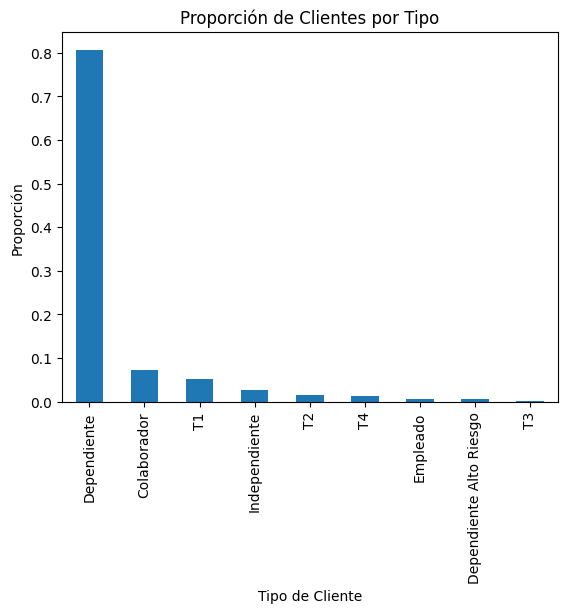

In [ ]:
# Contar las ocurrencias de cada tipo de cliente
tipo_cliente_counts = silver_product['TipoCliente'].value_counts()

# Calcular las proporciones
total_clientes = len(silver_product)
proporciones = tipo_cliente_counts / total_clientes

# Crear el gráfico de barras
proporciones.plot(kind='bar')
plt.title('Proporción de Clientes por Tipo')
plt.xlabel('Tipo de Cliente')
plt.ylabel('Proporción')
plt.show()

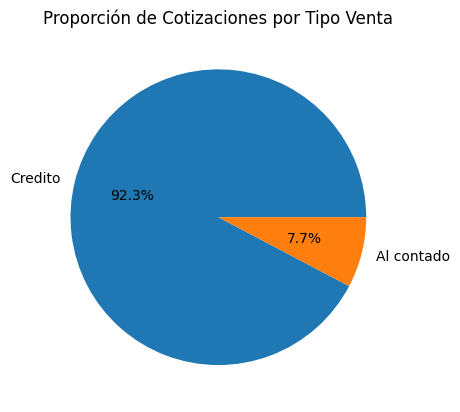

In [ ]:
estado_counts = silver_product['TipoVenta'].value_counts().sort_values(ascending=False)

# Calculate the total number of cotizaciones
total_cotizaciones = len(silver_product)

# Calculate the proportion for each 'EstadoCotizacion' value
estado_proportions = estado_counts / total_cotizaciones

# Create a pie chart to visualize the proportions
plt.pie(estado_proportions, labels=estado_proportions.index, autopct='%1.1f%%')
plt.title('Proporción de Cotizaciones por Tipo Venta')
plt.show()

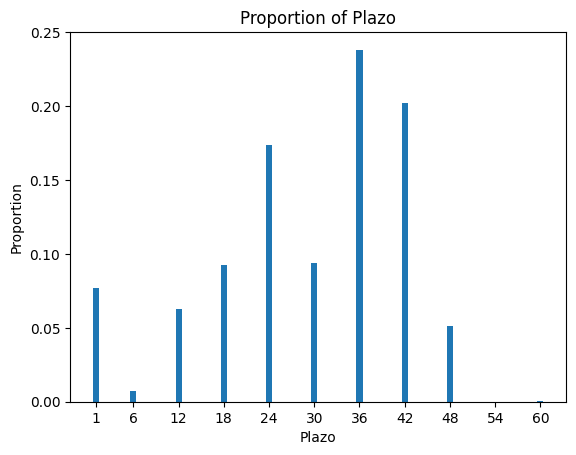

In [ ]:
# Count occurrences of each "Plazo" value
plazo_counts = silver_product['Plazo'].value_counts()

# Calculate total number of observations
total_observations = len(silver_product)

# Calculate proportions
proportions = plazo_counts / total_observations

# Create a bar chart
plt.bar(proportions.index, proportions.values)
plt.xticks(proportions.index)  # Display exact values on the x-axis
plt.title('Proportion of Plazo')
plt.xlabel('Plazo')
plt.ylabel('Proportion')
plt.show()

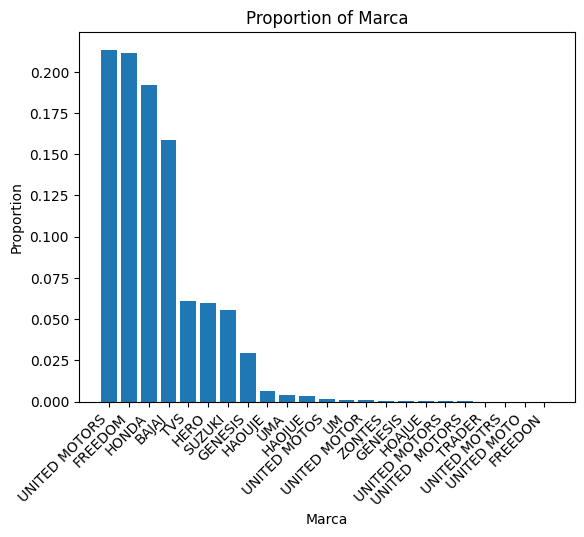

In [ ]:
marca_counts = silver_product['Marca'].value_counts()

# Calculate total number of observations
total_observations = len(silver_product)

# Calculate proportions
proportions = marca_counts / total_observations

# Create a bar chart
plt.bar(proportions.index, proportions.values)
plt.xticks(rotation=45, ha='right')  # Rotate labels 45 degrees and align right
plt.title('Proportion of Marca')
plt.xlabel('Marca')
plt.ylabel('Proportion')
plt.show()

#### Financial

In [ ]:
financial_dataframes = extract_product_dataframes(cotizacion_historial, 'Financial')

In [ ]:
financial_pivot = pivot_and_concatenate_dataframes(financial_dataframes)

In [ ]:
financial_pivot.head()

,IdCotizacion,ActividadEmpresa,Anios,AntiguedadEmpresa,AntiguedadLaboral,CantidadEmpleadosEmpresa,CantidadLocales,CapacidadDescuento,Cargo,CelularJefe,...,TelefonoTrabajo,TipoContrato,TipoLocalEmpresa,TipoSectorEmpresa,TipoSueldo,TrabajoAntCargo,TrabajoAntEmpresa,TrabajoAntFechaFin,TrabajoAntFechaInicio,TrabajoAntUltSalario
0,5,Prueba-,0-,3-,0-,2-,2-,0.00-,-,-,...,-,-,local-,sector-,-,-,-,-,-,0.00-
1,10,VENTAS AL POR MAYOR-,0-,147-,0-,15-,4-,0.00-,-,-,...,-,-,VENTAS-,VENTAS-,-,-,-,-,-,0.00-
2,8,VENTAS AL POR MAYOR-,0-,0-,0-,0-,0-,0.00-,CONTADOR JR.-,9000900-,...,8000900-,-5,-,-,-3,-,-,-,-,0.00-
3,17,-,-,0-,20-,0-,0-,0.00-,-,-,...,-,-,-,-,-,-,-,-,-,-
4,13,ABC-,0-,0-,0-,0-,0-,0.00-,Analista-,7293293-,...,34902923-,-3,-,-,-2,-,-,-,-,0.00-


In [ ]:
financial_pivot.to_csv('Financial.csv', index=False)

In [ ]:
import pandas as pd

In [ ]:
raw_financial = pd.read_csv('Financial.csv')
raw_financial.head()

,IdCotizacion,ActividadEmpresa,Anios,AntiguedadEmpresa,AntiguedadLaboral,CantidadEmpleadosEmpresa,CantidadLocales,CapacidadDescuento,Cargo,CelularJefe,...,TelefonoTrabajo,TipoContrato,TipoLocalEmpresa,TipoSectorEmpresa,TipoSueldo,TrabajoAntCargo,TrabajoAntEmpresa,TrabajoAntFechaFin,TrabajoAntFechaInicio,TrabajoAntUltSalario
0,5,Prueba-,0-,3-,0-,2-,2-,0.00-,-,-,...,-,-,local-,sector-,-,-,-,-,-,0.00-
1,10,VENTAS AL POR MAYOR-,0-,147-,0-,15-,4-,0.00-,-,-,...,-,-,VENTAS-,VENTAS-,-,-,-,-,-,0.00-
2,8,VENTAS AL POR MAYOR-,0-,0-,0-,0-,0-,0.00-,CONTADOR JR.-,9000900-,...,8000900-,-5,-,-,-3,-,-,-,-,0.00-
3,17,-,-,0-,20-,0-,0-,0.00-,-,-,...,-,-,-,-,-,-,-,-,-,-
4,13,ABC-,0-,0-,0-,0-,0-,0.00-,Analista-,7293293-,...,34902923-,-3,-,-,-2,-,-,-,-,0.00-


In [ ]:
raw_financial['ActividadEmpresa'] = raw_financial['ActividadEmpresa'].str.split('-').str[0]


In [ ]:
raw_financial['AntiguedadEmpresa'] = raw_financial['AntiguedadEmpresa'].apply(extract_integer)

In [ ]:
raw_financial['AntiguedadLaboral'] = raw_financial['AntiguedadLaboral'].apply(extract_integer)

In [ ]:
raw_financial['Cargo'] = raw_financial['Cargo'].str.split('-').str[0]

In [ ]:
raw_financial['Detalle'] = raw_financial['Detalle'].str.split('-').str[0]

In [ ]:
raw_financial['DiaPago'] = raw_financial['DiaPago'].apply(extract_integer)

In [ ]:
raw_financial['FormaPago'] = raw_financial['FormaPago'].apply(extract_integer)

In [ ]:
import re

def extract_number(value):
    cleaned_value = value.strip().strip('-')

    if not cleaned_value or cleaned_value == '--':
        return None

    cleaned_value = cleaned_value.replace(',', '')

    match = re.match(r'^(\d+(\.\d*)?)$', cleaned_value)
    if match:
        return float(match.group(1))

    match = re.match(r'^\d+$', cleaned_value)
    if match:
        return int(match.group(0))

    return None

In [ ]:
raw_financial['IngresoFijo'] = raw_financial['IngresoFijo'].apply(extract_number)

In [ ]:
raw_financial['IngresoVariable'] = raw_financial['IngresoVariable'].apply(extract_number)

In [ ]:
raw_financial['IngresoFijo'] = raw_financial['IngresoFijo'].fillna(0)

In [ ]:
raw_financial['IngresoVariable'] = raw_financial['IngresoVariable'].fillna(0)

In [ ]:
raw_financial['IngresoTotal'] = raw_financial['IngresoFijo'] + raw_financial['IngresoVariable']

In [ ]:
raw_financial['SalarioMensual'] = raw_financial['SalarioMensual'].apply(extract_number)

In [ ]:
raw_financial['TipoContrato'] = raw_financial['TipoContrato'].str.split('-').str[1]

In [ ]:
raw_financial['TipoLocalEmpresa'] = raw_financial['TipoLocalEmpresa'].str.split('-').str[0]

In [ ]:
raw_financial['TipoSueldo'] = raw_financial['TipoSueldo'].str.split('-').str[1]

In [ ]:
raw_financial['TipoContrato'] = raw_financial['TipoContrato'].fillna(0)

In [ ]:
raw_financial['TipoSueldo'] = raw_financial['TipoSueldo'].fillna(0)

In [ ]:
silver_financial = raw_financial[[
    'IdCotizacion',
    'ActividadEmpresa',
    'AntiguedadEmpresa',
    'AntiguedadLaboral',
    'IngresoFijo',
    'IngresoVariable',
    'IngresoTotal',
    'SalarioMensual',
    'TipoContrato',
    'TipoLocalEmpresa',
    'TipoSueldo'
]]

In [ ]:
silver_financial.to_csv('SilverFinancial.csv', index=False)

In [ ]:
silver_financial.head()

,IdCotizacion,ActividadEmpresa,AntiguedadEmpresa,AntiguedadLaboral,IngresoFijo,IngresoVariable,IngresoTotal,SalarioMensual,TipoContrato,TipoLocalEmpresa,TipoSueldo
0,5,Prueba,3,0,0.00,0.0,0.00,0.0,,local,
1,10,VENTAS AL POR MAYOR,147,0,0.00,0.0,0.00,0.0,,VENTAS,
2,8,VENTAS AL POR MAYOR,0,0,950.45,100.0,1050.45,0.0,5,,3
3,17,,0,20,0.00,0.0,0.00,852.0,,,
4,13,ABC,0,0,1000.00,500.0,1500.00,0.0,3,,2


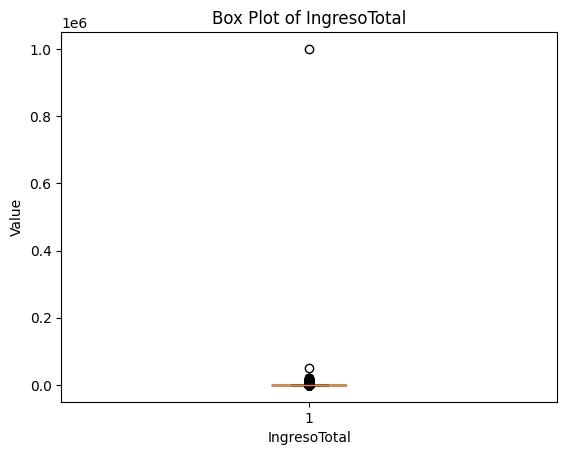

In [ ]:
import matplotlib.pyplot as plt

# Assuming you have the 'raw_financial' DataFrame defined
plt.boxplot(raw_financial['IngresoTotal'])
plt.xlabel('IngresoTotal')
plt.ylabel('Value')
plt.title('Box Plot of IngresoTotal')
plt.show()

In [ ]:
biggest_ingreso_total = silver_financial['IngresoTotal'].max()

print(biggest_ingreso_total)

1000000.0


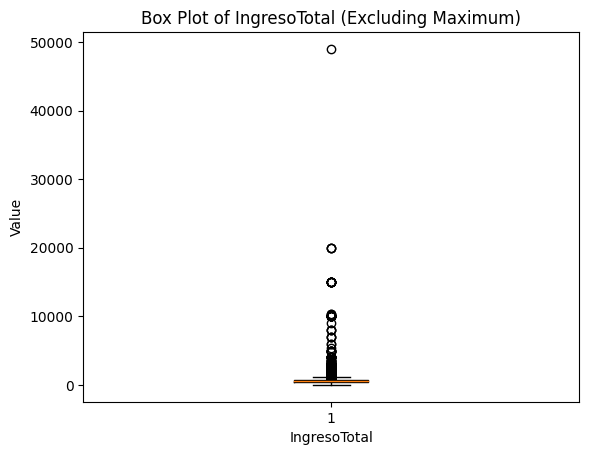

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Assuming your DataFrame is named 'raw_financial'

# Find the index of the maximum value
max_index = silver_financial['IngresoTotal'].idxmax()

# Remove the maximum value
data_without_max = silver_financial['IngresoTotal'].drop(max_index)

# Create the box plot
plt.boxplot(data_without_max)
plt.xlabel('IngresoTotal')
plt.ylabel('Value')
plt.title('Box Plot of IngresoTotal (Excluding Maximum)')
plt.show()

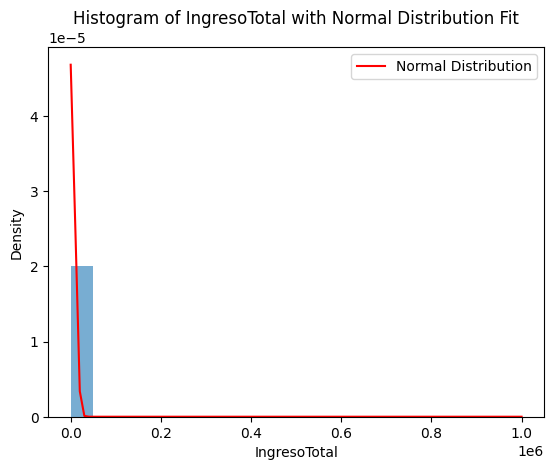

In [ ]:
import matplotlib.pyplot as plt
from scipy.stats import norm

# Assuming your DataFrame is named 'silver_financial'

# Calculate mean and standard deviation of IngresoTotal
mean_ingreso_total = silver_financial['IngresoTotal'].mean()
std_ingreso_total = silver_financial['IngresoTotal'].std()

# Generate x values for the normal distribution curve
x = np.linspace(min(silver_financial['IngresoTotal']), max(silver_financial['IngresoTotal']), 100)

# Calculate the probability density function (PDF) of the normal distribution
y = norm.pdf(x, mean_ingreso_total, std_ingreso_total)

# Plot histogram and normal distribution curve
plt.hist(silver_financial['IngresoTotal'], bins=20, density=True, alpha=0.6)
plt.plot(x, y, color='red', label='Normal Distribution')
plt.xlabel('IngresoTotal')
plt.ylabel('Density')
plt.title('Histogram of IngresoTotal with Normal Distribution Fit')
plt.legend()
plt.show()

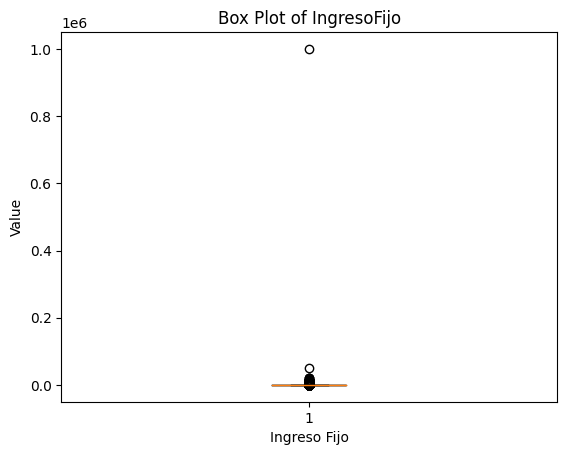

In [ ]:
plt.boxplot(silver_financial['IngresoFijo'])
plt.xlabel('Ingreso Fijo')
plt.ylabel('Value')
plt.title('Box Plot of IngresoFijo')
plt.show()

In [ ]:
biggest_ingreso_total = silver_financial['IngresoFijo'].max()

print(biggest_ingreso_total)

1000000.0


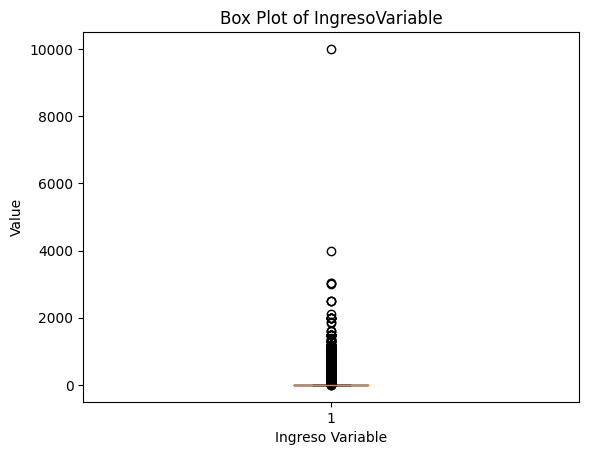

In [ ]:
plt.boxplot(silver_financial['IngresoVariable'])
plt.xlabel('Ingreso Variable')
plt.ylabel('Value')
plt.title('Box Plot of IngresoVariable')
plt.show()

In [ ]:
biggest_ingreso_total = silver_financial['IngresoVariable'].max()

print(biggest_ingreso_total)

10000.0


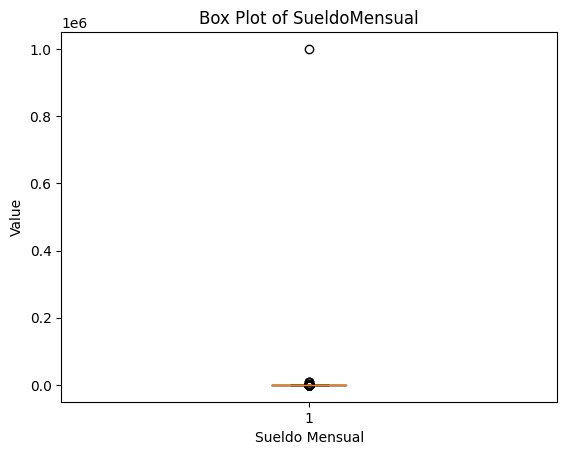

In [ ]:
plt.boxplot(silver_financial['SalarioMensual'])
plt.xlabel('Sueldo Mensual')
plt.ylabel('Value')
plt.title('Box Plot of SueldoMensual')
plt.show()

In [ ]:
biggest_ingreso_total = silver_financial['SalarioMensual'].max()

print(biggest_ingreso_total)

1000000.0


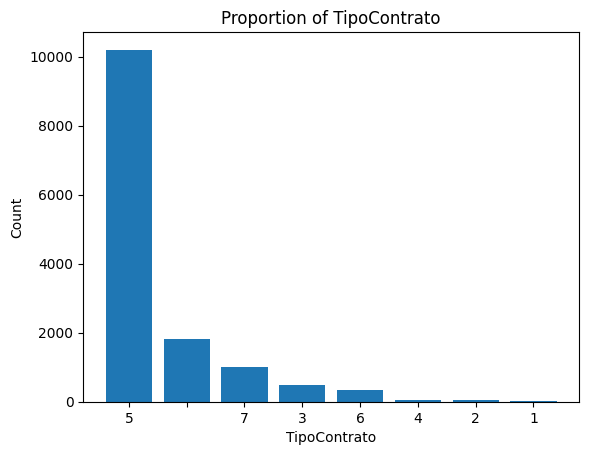

In [ ]:
tipo_contrato_counts = silver_financial['TipoContrato'].value_counts()
plt.bar(tipo_contrato_counts.index, tipo_contrato_counts)
plt.xlabel('TipoContrato')
plt.ylabel('Count')
plt.title('Proportion of TipoContrato')
plt.show()

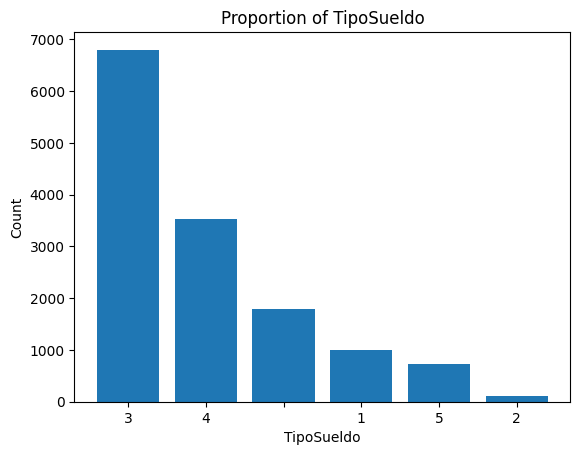

In [ ]:
tipo_sueldo_counts = silver_financial['TipoSueldo'].value_counts()
plt.bar(tipo_sueldo_counts.index, tipo_sueldo_counts)
plt.xlabel('TipoSueldo')
plt.ylabel('Count')
plt.title('Proportion of TipoSueldo')
plt.show()

#### Client

In [ ]:
client_dataframes = extract_product_dataframes(cotizacion_historial, 'Client')

In [ ]:
client_pivot = pivot_and_concatenate_dataframes(client_dataframes)

In [ ]:
client_pivot.head()

,IdCotizacion,AnioCarro,ApellidoCasada,CallePropiedad,CargoPep,CiudadPropiedad,ConocidoPor,Correo,DireccionAdicional,DireccionCliente,...,TiempoViviendo,TieneCarro,TienePropiedad,TipoDireccion,TipoIdentificador,TipoPropiedad,TipoVivienda,ValorCarro,ValorPropiedad,DepartamentoResidencia
0,5,2010-,-,-,None-,-,ANDREA MONTES-,-,"a, a, a, a, San Miguel, Lolotique, a-","b, b, b, b, La Unión, Lislique, v-",...,100-,SI-S,NO-N,None-1,None-46500,-,None-1,18789-,2332-,NaN
1,10,2000-,DOMINGUEZ-,2DA-,None-,SONSONATE-,MARIA GOMEZ ALARCON-,-,"25D, 45E, 55F, 65G, Sonsonate, Izalco, 25D, 45...","25D, 45E, 55F, 65G, Sonsonate, Izalco, 25D, 45...",...,95-,SI-S,SI-S,None-2,None-46500,LOTE-,None-5,3051.00-,4051.00-,NaN
2,8,2000-,DOMINGUEZ-,85 D NORTE-,None-,SAN MIGUEL-,MARIA GOMEZ ALARCON-,-,"PRIMERA D OESTE, PRIMERA, COLONIA 2000, 4562-1...","PRIMERA D OESTE, PRIMERA, COLONIA 2000, 4562-1...",...,125-,SI-S,SI-S,None-2,None-46500,LOTE-,None-5,3051.00-,4051.00-,NaN
3,13,a-,-,-,None-,-,MARIO CANIZALEZ-,-,"d, d, d, d, Ahuachapán, Apaneca, d-","c, c, c, c, La Libertad, San Matías, c-",...,12-,SI-S,NO-N,None-2,None-46500,-,None-1,122-,-,NaN
4,17,-,-,-,None-,-,JUAN ALARCON-,-,"31A, 31B, 31C, 31D, Sonsonate, Armenia, 31A-","31A, 31B, 31C, 31D, Sonsonate, Armenia, 31A-",...,95-,NO-N,NO-N,Urbana-2,None-46500,-,None-1,-,-,NaN


In [ ]:
client_pivot.to_csv('Client.csv', index=False)

In [ ]:
raw_client = pd.read_csv('Client.csv')

In [ ]:
client = raw_client.copy(deep = True)

In [ ]:
for column in client.columns:
    value_counts = client[column].value_counts()
    print(f"Value counts for '{column}':\n{value_counts}\n")

In [ ]:
bronze_client = client[[
    'IdCotizacion',
    'AnioCarro', # CUIDADO. Depende de fecha en que se aprobó Transformar a categoria de carro: nuevo, semi-nuevo, viejo...
    'CiudadPropiedad', # QUITAR??? Transformarlo a variable que indique si tiene o no propiedad
    'ConocidoPor', # Transformarlo a variable que indique si es que tiene referencia o no
    'Edad',
    'EstadoCivilReal',
    'Nacionalidad', # ??? PaisNacimiento
    'NivelEstudios',
    'NoDependientes',
    'NoSeguroSocial', # Tiene seguro social o no
    'Profesion',
    'TieneCarro',
    'TienePropiedad',
    'TipoDireccion',
    'ValorCarro',
    'ValorPropiedad'
]]

In [ ]:
silver_client = pd.DataFrame()

In [ ]:
silver_client['AnioCarro'] = bronze_client['AnioCarro'].apply(extract_integer)
print(silver_client['AnioCarro'].describe())

count      27.000000
mean     2011.296296
std         9.670792
min      1981.000000
25%      2005.500000
50%      2015.000000
75%      2018.500000
max      2022.000000
Name: AnioCarro, dtype: float64


In [ ]:
def tiene_referencia(conocido_por):
    first_value = conocido_por.split('-')[0]

    if len(first_value) > 1 and 'None' not in first_value:
        return 'SI'
    else:
        return 'NO'

silver_client['ConocidoPor'] = bronze_client['ConocidoPor']
silver_client['TieneReferencia'] = bronze_client['ConocidoPor'].apply(tiene_referencia)
print(silver_client.head())
silver_client = silver_client.drop('ConocidoPor', axis=1)

   AnioCarro           ConocidoPor TieneReferencia
0     2010.0        ANDREA MONTES-              SI
1     2000.0  MARIA GOMEZ ALARCON-              SI
2     2000.0  MARIA GOMEZ ALARCON-              SI
3        NaN      MARIO CANIZALEZ-              SI
4        NaN         JUAN ALARCON-              SI


In [ ]:
silver_client['Edad'] = bronze_client['Edad'].apply(extract_integer)
print(silver_client['Edad'].describe())

count    13978.000000
mean        31.691229
std          9.391935
min          0.000000
25%         25.000000
50%         30.000000
75%         37.000000
max        131.000000
Name: Edad, dtype: float64


In [ ]:
estado_civil_mapping = {
    1.0: 'Soltero',
    2.0: 'Casado',
    3.0: 'Viudo',
    4.0: 'Unión libre',
    5.0: 'Divorciado',
    6.0: 'Acompañado',
    7.0: 'Desconocido'
}
silver_client['EstadoCivilReal'] = bronze_client['EstadoCivilReal'].apply(extract_integer)
silver_client['EstadoCivil'] = silver_client['EstadoCivilReal'].map(estado_civil_mapping)
silver_client = silver_client.drop('EstadoCivilReal', axis=1)
print(silver_client['EstadoCivil'].value_counts())

EstadoCivil
Soltero        11051
Casado          2291
Acompañado       439
Unión libre       76
Divorciado        66
Desconocido       28
Viudo             22
Name: count, dtype: int64


In [ ]:
education_level_mapping = {
    1.0: 'Bachillerato',
    2.0: 'Básico',
    3.0: 'Ninguno',
    4.0: 'Universitario',
    5.0: 'No aplica'
}
silver_client['NivelEstudios'] = bronze_client['NivelEstudios'].apply(extract_integer)
silver_client['NivelEstudios'] = silver_client['NivelEstudios'].map(education_level_mapping)
print(silver_client['NivelEstudios'].value_counts())

NivelEstudios
Bachillerato     12490
Básico             818
Universitario      490
No aplica           28
Ninguno             19
Name: count, dtype: int64


In [ ]:
silver_client['NoDependientes'] = bronze_client['NoDependientes'].apply(extract_integer)
print(silver_client['NoDependientes'].describe())

count    13973.000000
mean         0.059758
std          0.437563
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max         15.000000
Name: NoDependientes, dtype: float64


In [ ]:
silver_client['ValorCarro'] = bronze_client['ValorCarro'].apply(extract_number)
print(silver_client['ValorCarro'].describe())

count       26.000000
mean      6448.615385
std       5848.252929
min        122.000000
25%       3051.000000
50%       3500.000000
75%      10025.000000
max      21000.000000
Name: ValorCarro, dtype: float64


In [ ]:
silver_client['ValorPropiedad'] = bronze_client['ValorPropiedad'].apply(extract_number)
print(silver_client['ValorPropiedad'].describe())

count        24.000000
mean      43682.458333
std       33466.135425
min          25.000000
25%       18000.000000
50%       45000.000000
75%       63500.000000
max      130000.000000
Name: ValorPropiedad, dtype: float64


In [ ]:
silver_client['Nacionalidad'] = bronze_client['Nacionalidad'].apply(lambda x: get_value(x, index=1))
silver_client['EsExtranjero'] = silver_client['Nacionalidad'].map(lambda x: 'NO' if x == 'SV' else 'SI')
silver_client = silver_client.drop('Nacionalidad', axis=1)

In [ ]:
silver_client['IdCotizacion'] = bronze_client['IdCotizacion']

In [ ]:
silver_client.head()

,AnioCarro,TieneReferencia,Edad,EstadoCivil,NivelEstudios,NoDependientes,ValorCarro,ValorPropiedad,EsExtranjero,IdCotizacion
0,2010.0,SI,32,Unión libre,No aplica,0.0,18789.0,2332.0,NO,5
1,2000.0,SI,36,Casado,Universitario,2.0,3051.0,4051.0,SI,10
2,2000.0,SI,36,Unión libre,Bachillerato,2.0,3051.0,4051.0,SI,8
3,NaN,SI,20,Soltero,Bachillerato,4.0,122.0,NaN,SI,13
4,NaN,SI,45,Acompañado,Bachillerato,1.0,NaN,NaN,SI,17


In [ ]:
silver_client.to_csv('SilverClient.csv', index=False)

#### Merge general

In [ ]:
silver_client = pd.read_csv('SilverClient.csv')
silver_financial = pd.read_csv('SilverFinancial.csv')
silver_product = pd.read_csv('SilverProduct.csv')

In [ ]:
merged_df = pd.merge(silver_client, silver_financial, on='IdCotizacion')
merged_df = pd.merge(merged_df, silver_product, on='IdCotizacion')

In [ ]:
merged_df.head()

,AnioCarro,TieneReferencia,Edad,EstadoCivil,NivelEstudios,NoDependientes,ValorCarro,ValorPropiedad,EsExtranjero,IdCotizacion,...,PrimaPor,Proposito,TipoCliente,TipoPromocion,TipoVenta,Valor,Meses,SueldoMinimo,TasaGobierno,Estado
0,2010.0,SI,32,Unión libre,No aplica,0.0,18789.0,2332.0,NO,5,...,0.25,1,Independiente,NaN,Credito,1800,NaN,NaN,NaN,NaN
1,2000.0,SI,36,Casado,Universitario,2.0,3051.0,4051.0,SI,10,...,0.36,2,Dependiente,NaN,Credito,1385,NaN,NaN,NaN,NaN
2,2000.0,SI,36,Unión libre,Bachillerato,2.0,3051.0,4051.0,SI,8,...,0.52,3,Dependiente,NaN,Credito,1090,NaN,NaN,NaN,NaN
3,NaN,SI,20,Soltero,Bachillerato,4.0,122.0,NaN,SI,13,...,0.26,2,Dependiente Alto Riesgo,NaN,Al contado,1410,NaN,NaN,NaN,NaN
4,NaN,SI,45,Acompañado,Bachillerato,1.0,NaN,NaN,SI,17,...,0.00,2,Colaborador,NaN,Al contado,1385,NaN,NaN,NaN,NaN


In [ ]:
merged_df.info()

In [ ]:
# prompt: rename Estado to ProductoEstado in merged_df

silver_merge = merged_df[[
    # 'AnioCarro',
    'TieneReferencia',
    'Edad',
    'EstadoCivil',
    'NivelEstudios',
    'NoDependientes',
    'ValorCarro',
    'ValorPropiedad',
    'EsExtranjero',
    'IdCotizacion',
    # 'ActividadEmpresa',
    'AntiguedadEmpresa',
    'AntiguedadLaboral',
    'IngresoFijo',
    'IngresoVariable',
    #'IngresoTotal',
    'SalarioMensual',
    'TipoContrato',
    #'TipoLocalEmpresa',
    'TipoSueldo',
    'Anio',
    #'DescuentoMonto',
    #'DescuentoPor',
    'EstadoCotizacion',
    'FuenteNegocio',
    #'Marca',
    'MontoSolicitado',
    'Plazo',
    'PrimaMonto',
    'PrimaPor',
    'Proposito',
    'TipoCliente',
    #'TipoPromocion',
    'TipoVenta',
    'Valor',
    #'Meses',
    'SueldoMinimo',
    'TasaGobierno',
    'Estado',
    ]].rename(
    columns={
        'Anio': 'AnioProducto',
        'Valor': 'ValorProducto',
        'Estado': 'EstadoProducto',
        }
)
silver_merge.head()


,TieneReferencia,Edad,EstadoCivil,NivelEstudios,NoDependientes,ValorCarro,ValorPropiedad,EsExtranjero,IdCotizacion,AntiguedadEmpresa,...,Plazo,PrimaMonto,PrimaPor,Proposito,TipoCliente,TipoVenta,ValorProducto,SueldoMinimo,TasaGobierno,EstadoProducto
0,SI,32,Unión libre,No aplica,0.0,18789.0,2332.0,NO,5,3,...,6,2500.0,0.25,1,Independiente,Credito,1800,NaN,NaN,NaN
1,SI,36,Casado,Universitario,2.0,3051.0,4051.0,SI,10,147,...,18,498.6,0.36,2,Dependiente,Credito,1385,NaN,NaN,NaN
2,SI,36,Unión libre,Bachillerato,2.0,3051.0,4051.0,SI,8,0,...,24,566.8,0.52,3,Dependiente,Credito,1090,NaN,NaN,NaN
3,SI,20,Soltero,Bachillerato,4.0,122.0,NaN,SI,13,0,...,1,366.6,0.26,2,Dependiente Alto Riesgo,Al contado,1410,NaN,NaN,NaN
4,SI,45,Acompañado,Bachillerato,1.0,NaN,NaN,SI,17,0,...,1,0.0,0.00,2,Colaborador,Al contado,1385,NaN,NaN,NaN


In [ ]:
# prompt: i need to count null and nan for each column of silver_merge

# Count null values
null_counts = silver_merge.isnull().sum()

# Count NaN values
nan_counts = silver_merge.isna().sum()

# Print the counts
print("Null value counts:\n", null_counts)
print("\nNaN value counts:\n", nan_counts)


Null value counts:
 TieneReferencia          0
Edad                     0
EstadoCivil              5
NivelEstudios          133
NoDependientes           5
ValorCarro           13952
ValorPropiedad       13954
EsExtranjero             0
IdCotizacion             0
AntiguedadEmpresa        0
AntiguedadLaboral        0
IngresoFijo              0
IngresoVariable          0
SalarioMensual           0
TipoContrato          1826
TipoSueldo            1792
AnioProducto             0
EstadoCotizacion         0
FuenteNegocio           24
MontoSolicitado          0
Plazo                    0
PrimaMonto               0
PrimaPor                 0
Proposito                0
TipoCliente              0
TipoVenta                0
ValorProducto            0
SueldoMinimo          4480
TasaGobierno          4480
EstadoProducto       11587
dtype: int64

NaN value counts:
 TieneReferencia          0
Edad                     0
EstadoCivil              5
NivelEstudios          133
NoDependientes           5
Va

In [ ]:
# prompt: if (silver_merge['IngresoFijo'] == 0) & (silver_merge['SalarioMensual'] != 0)  Sum SalarioMensual to IngresoTotal

import numpy as np
silver_merge['IngresoFijo'] = np.where(
    (silver_merge['IngresoFijo'] == 0) & (silver_merge['SalarioMensual'] != 0),
    silver_merge['IngresoFijo'] + silver_merge['SalarioMensual'],
    silver_merge['IngresoFijo']
)

silver_merge = silver_merge.drop('SalarioMensual', axis=1)


In [ ]:
# prompt: set "Desconocido" to nulls in EstadoCivil

silver_merge['EstadoCivil'] = silver_merge['EstadoCivil'].fillna('Desconocido')
print(silver_merge['EstadoCivil'].value_counts())


EstadoCivil
Soltero        11051
Casado          2291
Acompañado       439
Unión libre       76
Divorciado        66
Desconocido       33
Viudo             22
Name: count, dtype: int64


In [ ]:
# prompt: set "No Especifica" to nulls in NivelEstudios in silver_merge

silver_merge['NivelEstudios'] = silver_merge['NivelEstudios'].fillna('No aplica')
print(silver_merge['NivelEstudios'].value_counts())

NivelEstudios
Bachillerato     12490
Básico             818
Universitario      490
No aplica          161
Ninguno             19
Name: count, dtype: int64


In [ ]:
silver_merge['NoDependientes'] = silver_merge['NoDependientes'].fillna(0)
print(silver_merge['NoDependientes'].value_counts())

NoDependientes
0.0     13471
1.0       311
2.0       151
3.0        26
4.0        11
15.0        6
5.0         2
Name: count, dtype: int64


In [ ]:
silver_merge['ValorCarro'] = silver_merge['ValorCarro'].fillna(0)
print(silver_merge['ValorCarro'].value_counts())

ValorCarro
0.0        13952
3200.0         3
3500.0         3
3051.0         3
10500.0        2
18789.0        1
900.0          1
7500.0         1
1300.0         1
7000.0         1
1200.0         1
950.0          1
21000.0        1
15100.0        1
15000.0        1
5500.0         1
8600.0         1
12450.0        1
122.0          1
2000.0         1
Name: count, dtype: int64


In [ ]:
silver_merge['TipoContrato'] = silver_merge['TipoContrato'].fillna(0)
print(silver_merge['TipoContrato'].value_counts())
# 0 = desconocido

TipoContrato
5.0    10197
0.0     1826
7.0     1017
3.0      493
6.0      354
4.0       40
2.0       39
1.0       12
Name: count, dtype: int64


In [ ]:
silver_merge['TipoSueldo'] = silver_merge['TipoSueldo'].fillna(0)
print(silver_merge['TipoSueldo'].value_counts())
# 0 = desconocido

TipoSueldo
3.0    6801
4.0    3537
0.0    1792
1.0    1008
5.0     733
2.0     107
Name: count, dtype: int64


In [ ]:
silver_merge = silver_merge.rename(columns={'EstadoCotizacion': 'Aprobado'})
silver_merge['Aprobado'] = silver_merge['Aprobado'].map(lambda x: 1 if x == 10 else 0)
print(silver_merge['Aprobado'].value_counts())

Aprobado
1    11804
0     2174
Name: count, dtype: int64


In [ ]:
silver_merge['FuenteNegocio'] = silver_merge['FuenteNegocio'].fillna(0)
print(silver_merge['FuenteNegocio'].value_counts())
# 0 = desconocido

FuenteNegocio
9.0    10943
1.0     1130
3.0      895
5.0      499
2.0      407
7.0       31
4.0       26
0.0       24
6.0       13
8.0       10
Name: count, dtype: int64


In [ ]:
silver_merge['SueldoMinimo'] = silver_merge['SueldoMinimo'].fillna(0)
print(silver_merge['SueldoMinimo'].value_counts())
# 0 = necesita minimo

SueldoMinimo
700.0    7557
0.0      4480
365.0    1900
300.0      41
Name: count, dtype: int64


In [ ]:
silver_merge['TasaGobierno'] = silver_merge['TasaGobierno'].fillna(0)
print(silver_merge['TasaGobierno'].value_counts())

TasaGobierno
35.0    9346
0.0     4480
22.0      83
44.0      69
Name: count, dtype: int64


In [ ]:
silver_merge['EstadoProducto'] = silver_merge['EstadoProducto'].fillna("Desconocido")
print(silver_merge['EstadoProducto'].value_counts())
# Desconocido =  Desconocido/Moto Nueva

EstadoProducto
Desconocido     11587
Consignación     2294
Usado              97
Name: count, dtype: int64


In [ ]:
silver_merge.to_csv('SilverMerge.csv', index=False)

In [ ]:
silver_merge = pd.read_csv('SilverMerge.csv')
silver_merge.head()

,TieneReferencia,Edad,EstadoCivil,NivelEstudios,NoDependientes,ValorCarro,ValorPropiedad,EsExtranjero,IdCotizacion,AntiguedadEmpresa,...,Plazo,PrimaMonto,PrimaPor,Proposito,TipoCliente,TipoVenta,ValorProducto,SueldoMinimo,TasaGobierno,EstadoProducto
0,SI,32,Unión libre,No aplica,0.0,18789.0,2332.0,NO,5,3,...,6,2500.0,0.25,1,Independiente,Credito,1800,0.0,0.0,Desconocido
1,SI,36,Casado,Universitario,2.0,3051.0,4051.0,SI,10,147,...,18,498.6,0.36,2,Dependiente,Credito,1385,0.0,0.0,Desconocido
2,SI,36,Unión libre,Bachillerato,2.0,3051.0,4051.0,SI,8,0,...,24,566.8,0.52,3,Dependiente,Credito,1090,0.0,0.0,Desconocido
3,SI,20,Soltero,Bachillerato,4.0,122.0,NaN,SI,13,0,...,1,366.6,0.26,2,Dependiente Alto Riesgo,Al contado,1410,0.0,0.0,Desconocido
4,SI,45,Acompañado,Bachillerato,1.0,0.0,NaN,SI,17,0,...,1,0.0,0.00,2,Colaborador,Al contado,1385,0.0,0.0,Desconocido


In [ ]:
columns = silver_merge.columns.tolist()
columns

['TieneReferencia',
 'Edad',
 'EstadoCivil',
 'NivelEstudios',
 'NoDependientes',
 'ValorCarro',
 'ValorPropiedad',
 'EsExtranjero',
 'IdCotizacion',
 'AntiguedadEmpresa',
 'AntiguedadLaboral',
 'IngresoFijo',
 'IngresoVariable',
 'TipoContrato',
 'TipoSueldo',
 'AnioProducto',
 'Aprobado',
 'FuenteNegocio',
 'MontoSolicitado',
 'Plazo',
 'PrimaMonto',
 'PrimaPor',
 'Proposito',
 'TipoCliente',
 'TipoVenta',
 'ValorProducto',
 'SueldoMinimo',
 'TasaGobierno',
 'EstadoProducto']

In [ ]:
gold_merge = silver_merge.copy(deep = True)
gold_merge = gold_merge.drop('IdCotizacion', axis=1)

In [ ]:
gold_merge['Aprobado'] = silver_merge['Aprobado'].replace({'SI': 1, 'NO': 0})
gold_merge['TieneReferencia'] = silver_merge['TieneReferencia'].replace({'SI': 1, 'NO': 0})
gold_merge['EsExtranjero'] = silver_merge['EsExtranjero'].replace({'SI': 1, 'NO': 0})

In [ ]:
categorical_columns = ['EstadoCivil', 'NivelEstudios', 'TipoContrato', 'TipoSueldo', 'FuenteNegocio', 'Proposito', 'TipoCliente', 'TipoVenta', 'EstadoProducto']

for col in categorical_columns:
    # Create dummy variables
    dummies = pd.get_dummies(gold_merge[col], prefix=col, dtype=int)

    # Concatenate dummy variables to the original DataFrame
    gold_merge = pd.concat([gold_merge, dummies], axis=1)

    # Drop the original categorical column
    gold_merge = gold_merge.drop(col, axis=1)

In [ ]:
gold_merge['ValorPropiedad'] = gold_merge['ValorPropiedad'].fillna(0)

In [ ]:
gold_merge[['TieneReferencia', 'Aprobado']]

,TieneReferencia,Aprobado
0,1,1
1,1,1
2,1,1
3,1,1
4,1,1
...,...,...
13973,0,1
13974,0,1
13975,0,1
13976,0,1


In [ ]:
columns = gold_merge.columns.tolist()
len(columns)

74

In [ ]:
for column in gold_merge.columns:
    value_counts = gold_merge[column].value_counts()
    print(f"Value counts for '{column}':\n{value_counts}\n")

In [ ]:
from sklearn.feature_selection import SelectKBest, mutual_info_classif
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import MinMaxScaler

y = gold_merge['Aprobado']
X = gold_merge.drop('Aprobado', axis=1)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train_scaled, y_train)

             Feature     Score
0               Edad  0.379144
1      ValorProducto  0.305319
2    MontoSolicitado  0.304600
3         PrimaMonto  0.274366
4        IngresoFijo  0.234420
5           PrimaPor  0.226389
6              Plazo  0.219832
7       AnioProducto  0.126130
8    IngresoVariable  0.060550
9  TipoVenta_Credito  0.036462
                 Feature     Score
0                   Edad  0.377953
1        MontoSolicitado  0.301643
2          ValorProducto  0.300403
3             PrimaMonto  0.272438
4            IngresoFijo  0.231946
5               PrimaPor  0.228781
6                  Plazo  0.222747
7           AnioProducto  0.127086
8        IngresoVariable  0.057675
9   TipoVenta_Al contado  0.034854
10     TipoVenta_Credito  0.030051
                 Feature     Score
0                   Edad  0.377381
1          ValorProducto  0.304736
2        MontoSolicitado  0.301519
3             PrimaMonto  0.278020
4            IngresoFijo  0.236641
5               PrimaPor  0.2

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


                    Feature     Score
0                      Edad  0.378570
1             ValorProducto  0.308158
2           MontoSolicitado  0.301514
3                PrimaMonto  0.273796
4               IngresoFijo  0.235720
5                  PrimaPor  0.229174
6                     Plazo  0.220703
7              AnioProducto  0.127849
8           IngresoVariable  0.065093
9      TipoVenta_Al contado  0.030006
10        TipoVenta_Credito  0.029762
11        AntiguedadLaboral  0.026812
12             SueldoMinimo  0.023929
13  TipoCliente_Colaborador  0.019345
14      EstadoCivil_Soltero  0.019232
                 Feature     Score
0                   Edad  0.373185
1          ValorProducto  0.304398
2        MontoSolicitado  0.298658
3             PrimaMonto  0.273436
4            IngresoFijo  0.238104
5               PrimaPor  0.230572
6                  Plazo  0.219349
7           AnioProducto  0.117500
8        IngresoVariable  0.066069
9   TipoVenta_Al contado  0.036875
10     

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


                 Feature     Score
0                   Edad  0.376725
1        MontoSolicitado  0.302323
2          ValorProducto  0.300664
3             PrimaMonto  0.274925
4            IngresoFijo  0.236695
5               PrimaPor  0.229429
6                  Plazo  0.220404
7           AnioProducto  0.121341
8        IngresoVariable  0.062155
9      TipoVenta_Credito  0.042616
10  TipoVenta_Al contado  0.037716
11     AntiguedadLaboral  0.023625
12          SueldoMinimo  0.020651
13   EstadoCivil_Soltero  0.020561
14      TipoContrato_0.0  0.019045
15        TipoSueldo_0.0  0.017247
16      TipoContrato_5.0  0.015788
                    Feature     Score
0                      Edad  0.375150
1           MontoSolicitado  0.302870
2             ValorProducto  0.302701
3                PrimaMonto  0.276308
4               IngresoFijo  0.236792
5                  PrimaPor  0.230835
6                     Plazo  0.217259
7              AnioProducto  0.119593
8           IngresoVariable 

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


                       Feature     Score
0                         Edad  0.375086
1                ValorProducto  0.302684
2              MontoSolicitado  0.301949
3                   PrimaMonto  0.274277
4                  IngresoFijo  0.235131
5                     PrimaPor  0.228387
6                        Plazo  0.215600
7                 AnioProducto  0.121994
8              IngresoVariable  0.070117
9            TipoVenta_Credito  0.041313
10        TipoVenta_Al contado  0.030869
11           AntiguedadLaboral  0.024598
12            TipoContrato_0.0  0.024458
13         EstadoCivil_Soltero  0.023618
14                SueldoMinimo  0.023477
15              TipoSueldo_0.0  0.020978
16            TipoContrato_5.0  0.018880
17  NivelEstudios_Bachillerato  0.016459
18                TasaGobierno  0.016269


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


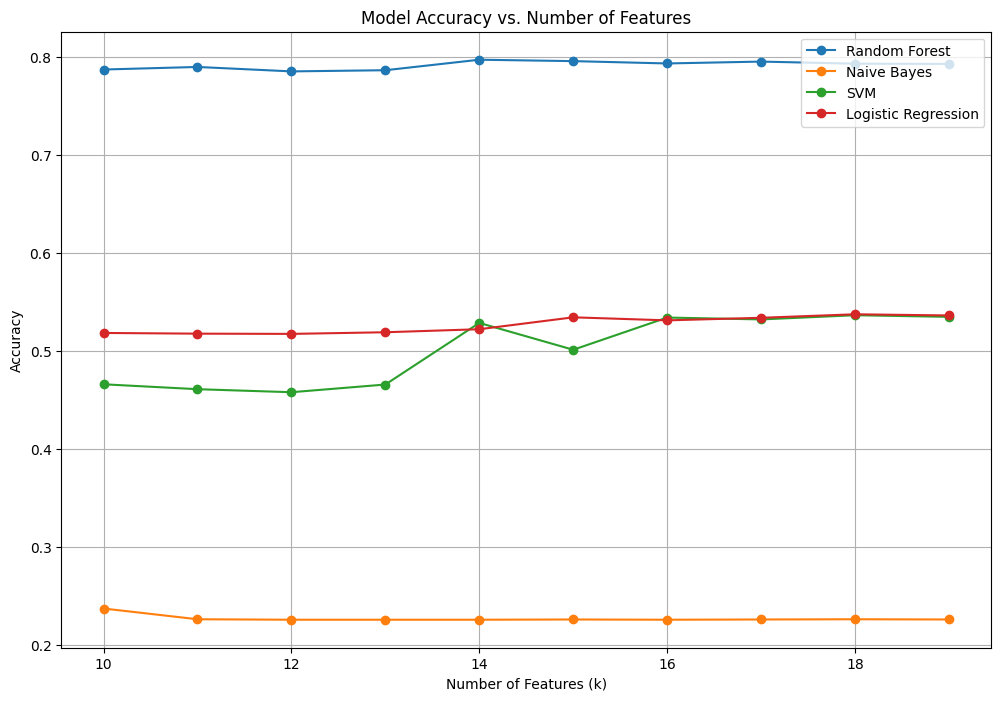

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression


models = {
    'Random Forest': RandomForestClassifier(),
    'Naive Bayes': GaussianNB(),
    'SVM': SVC(),
    'Logistic Regression': LogisticRegression()
}

# Define range for k
k_values = range(10, 20)

# Store results
results = {name: [] for name in models.keys()}

# Iterate through different values of k
for k in k_values:
    # Feature selection
    selector = SelectKBest(mutual_info_classif, k=k)
    X_train_selected = selector.fit_transform(X_train_resampled, y_train_resampled)
    X_test_selected = selector.transform(X_test_scaled)


    mask = selector.get_support()
    selected_feature_names = X.columns[mask]
    scores = selector.scores_

    feature_table = pd.DataFrame({'Feature': X.columns, 'Score': scores})
    feature_table = feature_table.sort_values(by='Score', ascending=False).reset_index(drop=True)

    top_features_table = feature_table.head(k)

    print(top_features_table)

    # Evaluate models
    for name, model in models.items():
        # Train the model
        model.fit(X_train_selected, y_train_resampled)

        # Predict on the test data
        y_pred = model.predict(X_test_selected)

        # Evaluate the model
        accuracy = accuracy_score(y_test, y_pred)
        results[name].append(accuracy)

# Plot results
plt.figure(figsize=(12, 8))
for name, accuracies in results.items():
    plt.plot(k_values, accuracies, marker='o', label=name)

plt.xlabel('Number of Features (k)')
plt.ylabel('Accuracy')
plt.title('Model Accuracy vs. Number of Features')
plt.legend()
plt.grid(True)
plt.show()


In [ ]:
# Check for data leakage
print("Training set size:", X_train.shape)
print("Test set size:", X_test.shape)

# Check class distribution
print("Training set class distribution:")
print(y_train.value_counts())
print("Test set class distribution:")
print(y_test.value_counts())

# Check model predictions
print("Sample predictions:", y_pred[:10])
print("Sample true values:", y_test.values[:10])

# Check feature selection
print("Number of features selected:", X_train_selected.shape[1])


In [ ]:
y_pred

array([0, 0, 0, ..., 0, 0, 0])

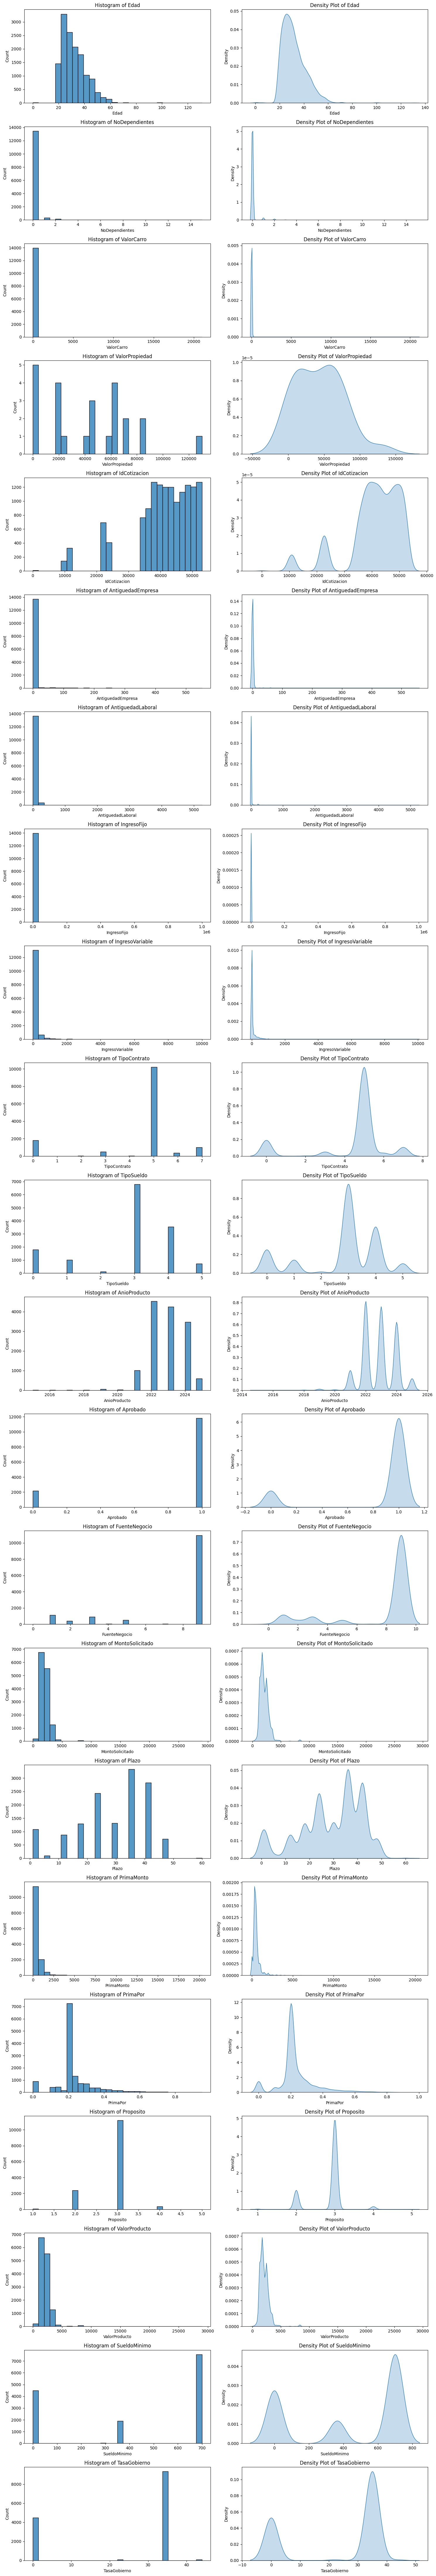

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming 'df' is your DataFrame
# Selecting only numeric columns
numeric_columns = silver_merge.select_dtypes(include=['number']).columns

# Set the size of the overall figure
plt.figure(figsize=(15, len(numeric_columns) * 4))

# Loop through each numeric column and create a subplot for it
for i, column in enumerate(numeric_columns):
    plt.subplot(len(numeric_columns), 2, 2*i + 1)  # Position for histogram
    sns.histplot(silver_merge[column], kde=False, bins=30)
    plt.title(f'Histogram of {column}')

    plt.subplot(len(numeric_columns), 2, 2*i + 2)  # Position for density plot
    sns.kdeplot(silver_merge[column], fill=True)
    plt.title(f'Density Plot of {column}')

# Adjust layout to prevent overlap
plt.tight_layout()
plt.show()


/usr/local/lib/python3.10/dist-packages/statsmodels/stats/outliers_influence.py:197: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)


              feature         VIF
0                Edad   73.092092
1      NoDependientes   25.543197
2          ValorCarro    9.231300
3      ValorPropiedad   37.170673
4        IdCotizacion   77.297434
5   AntiguedadEmpresa   20.767021
6   AntiguedadLaboral    9.571840
7         IngresoFijo   76.187553
8     IngresoVariable    5.177175
9        TipoContrato   32.361935
10         TipoSueldo   23.746953
11       AnioProducto  484.311256
12           Aprobado   73.541208
13      FuenteNegocio   21.977223
14    MontoSolicitado         inf
15              Plazo   29.337104
16         PrimaMonto   64.807267
17           PrimaPor   68.835542
18          Proposito  120.346380
19      ValorProducto         inf
20       SueldoMinimo  163.886732
21       TasaGobierno  182.009042


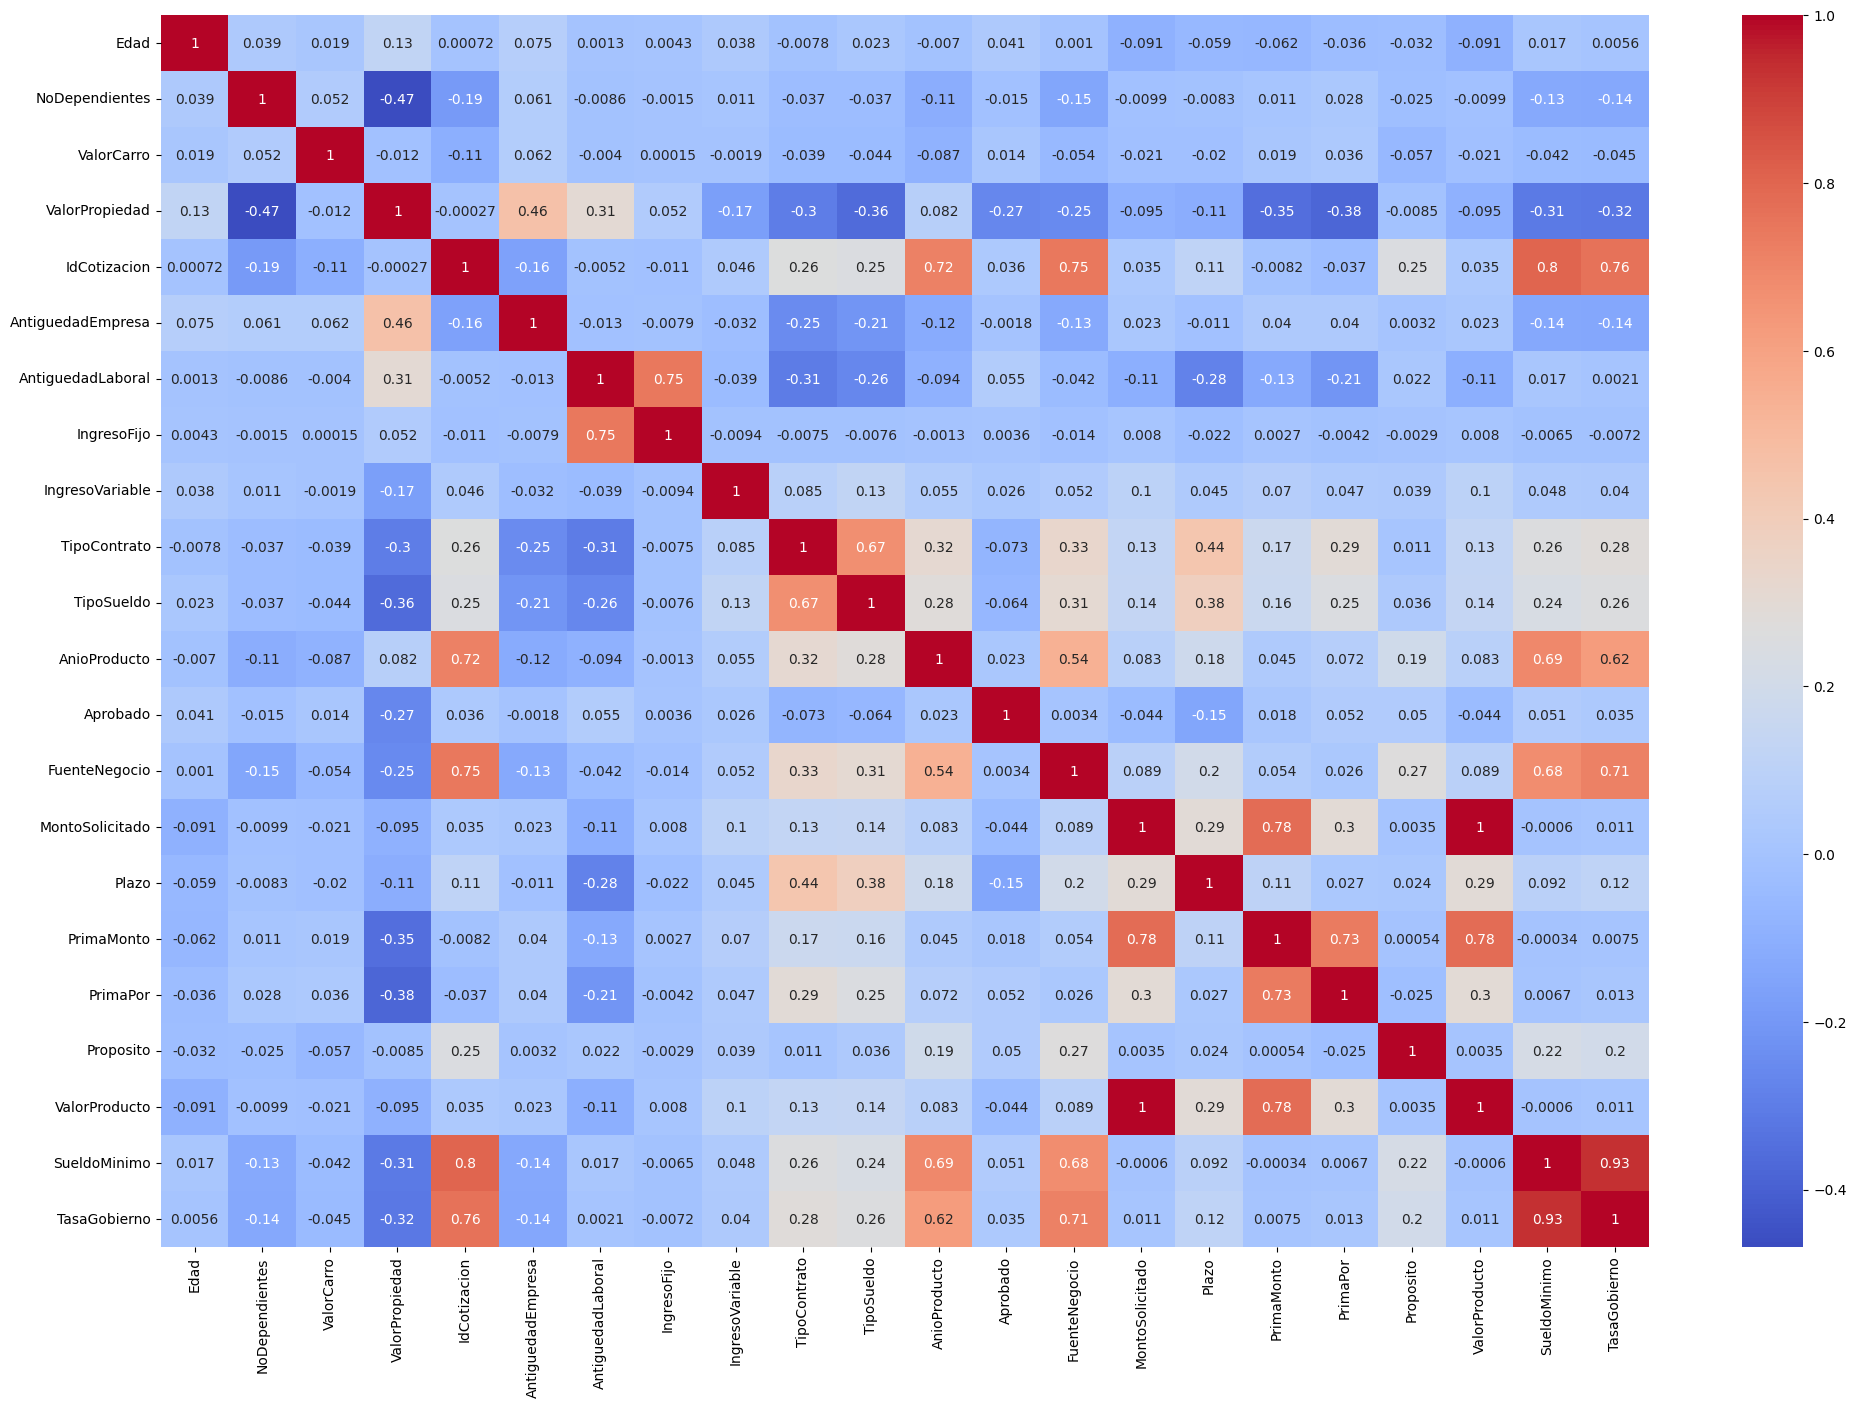

In [ ]:
import numpy as np
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.stats.outliers_influence import variance_inflation_factor

# Select all numerical columns
numerical_columns = silver_merge.select_dtypes(include=[np.number]).columns

# Increase the size of the heatmap
plt.figure(figsize=(24, 16))  # Adjust the width and height as needed

# Correlation matrix
corr_matrix = silver_merge[numerical_columns].corr()
sns.heatmap(corr_matrix, annot=True, cmap="coolwarm")

# Variance Inflation Factor (VIF)
X = silver_merge[numerical_columns].dropna()  # Handle missing values if any
vif_data = pd.DataFrame()
vif_data["feature"] = X.columns
vif_data["VIF"] = [variance_inflation_factor(X.values, i) for i in range(len(X.columns))]

print(vif_data)

plt.show()  # Display the heatmap


#### Carga (OBSOLETO)

In [ ]:
def categorize_year(year):
    if year == -1:
        return 'No tiene'
    current_year = pd.Timestamp.now().year
    if year > current_year - 5:
        return 'Moderno'
    elif year > current_year - 15:
        return 'Viejo'
    else:
        return 'Muy viejo'

In [ ]:
silver_client['anio_carro'] = client['AnioCarro'].apply(extract_year)
silver_client['anio_carro'].fillna(-1, inplace=True)
silver_client['categoria_carro'] = silver_client['anio_carro'].apply(categorize_year)

In [ ]:
distribution = silver_client['categoria_carro'].value_counts()
print(distribution)

categoria_carro
No tiene     28342
Muy viejo       46
Viejo           29
Moderno          7
Name: count, dtype: int64


## Cotizacion

In [ ]:
with pool.connect() as db_conn:
    # Use pd.read_sql to directly load the query results into a DataFrame
    raw_cotizacion = pd.read_sql(text("select CotizacionId, FechaCreacion, FechaEdicion, Estado, IdSucursal, IdCotizador, IdPantallaActual from CreditFactory.Cotizacion"), db_conn)

raw_cotizacion.head()

,CotizacionId,FechaCreacion,FechaEdicion,Estado,IdSucursal,IdCotizador,IdPantallaActual
0,3,2020-12-07 17:47:24.550,2020-12-07 17:47:24.997,1,0,2751,11004
1,4,2020-12-07 19:38:48.027,2020-12-17 15:58:10.693,1,0,2751,11004
2,5,2020-12-08 08:33:39.873,2020-12-17 19:22:15.943,10,0,2751,11003
3,6,2020-12-08 11:34:24.987,2020-12-08 11:34:25.377,1,0,2751,11004
4,7,2020-12-09 16:15:54.423,2021-01-19 07:30:07.700,2,0,2751,11002


In [ ]:
silver_cotizacion = raw_cotizacion[[
    'CotizacionId',
    'FechaCreacion',
    'FechaEdicion',
    'Estado',
    'IdSucursal',
    'IdCotizador',
    'IdPantallaActual'
    ]].rename(
    columns={
        'CotizacionId': 'id_cotizacion',
        'FechaCreacion': 'fecha_creacion',
        'FechaEdicion': 'fecha_edicion',
        'Estado': 'estado',
        'IdSucursal': 'id_sucursal',
        'IdCotizador': 'id_cotizador',
        'IdPantallaActual': 'id_pantalla_actual'
        }
)

## Catalogo Detalle
Necesario para obtener los nombres de los estados

In [ ]:
with pool.connect() as db_conn:
    # Use pd.read_sql to directly load the query results into a DataFrame
    raw_catalogo_detalle = pd.read_sql(text("select Valor, Texto, IdCatalogo from CreditFactory.Catalogo_Detalle"), db_conn)

raw_catalogo_detalle.head()

,Valor,Texto,IdCatalogo
0,CRC-P,Principal,1
1,CRG-P,Principal,2
2,CRU-P,Principal,3
3,1,Creación,4
4,2,Edición,4


In [ ]:
silver_catalogo_detalle = raw_catalogo_detalle[[
    'Valor',
    'Texto',
    'IdCatalogo'
    ]].rename(
    columns={
        'Valor': 'valor',
        'Texto': 'texto',
        'IdCatalogo': 'id_catalogo'
        }
)

In [ ]:
silver_catalogo_detalle.head()

,valor,texto,id_catalogo
2220,1,En proceso,29
2221,2,Desistido,29
2222,3,Rechazado,29
2223,4,En Aprobación,29
2224,5,En Trámite,29


In [ ]:
silver_catalogo_detalle = silver_catalogo_detalle[silver_catalogo_detalle['id_catalogo'] == 29]

## Cotizacion Historial
Historico de movimientos sobre la cotizacion

In [ ]:
with pool.connect() as db_conn:
    # Use pd.read_sql to directly load the query results into a DataFrame
    raw_cotizacion_historial = pd.read_sql(text('SELECT * FROM CreditFactory.Cotizacion_Historial WHERE Estado IN (3, 10)'), db_conn)

raw_cotizacion_historial.head()

,Id,Pantallas,IdOperacion,Fecha,IdCotizacion,IdUsuario,Estado,Comentario,row_number
0,240,"{""Origination"":null,""Client"":{""Alias"":""CLNT"",""...",5,2020-12-17 19:22:15.943,5,0,10,Gestión: Aprobado,1
1,513,"{""Origination"":null,""Client"":{""Alias"":""CLNT"",""...",5,2020-12-30 19:46:54.310,10,2,10,Gestión: Aprobado,1
2,209,"{""Origination"":null,""Client"":{""Alias"":""CLNT"",""...",5,2020-12-17 16:22:13.507,8,2,10,Gestión: Aprobado,1
3,508,"{""Origination"":null,""Client"":{""Alias"":""CLNT"",""...",5,2020-12-30 19:25:51.677,13,2,10,Gestión: Aprobado,1
4,366,"{""Origination"":null,""Client"":{""Alias"":""CLNT"",""...",5,2020-12-24 14:29:19.480,17,2,10,Gestión: Aprobado,1


### Procesamiento

In [ ]:
silver_cotizacion_historial = raw_cotizacion_historial[[
    'Id',
    'Pantallas',
    'IdOperacion',
    'Fecha',
    'IdCotizacion',
    'Estado'
    ]].rename(
    columns={
        'Id': 'id_cotizacion_historial',
        'Pantallas': 'pantallas',
        'IdOperacion': 'id_operacion',
        'Fecha': 'fecha',
        'IdCotizacion': 'id_cotizacion',
        'Estado': 'estado'
        }
)

In [ ]:
silver_cotizacion_historial.head()

,id_cotizacion_historial,pantallas,id_operacion,fecha,id_cotizacion,estado
0,7,"{""Origination"":null,""Client"":null,""Financial"":...",4,2020-12-07 17:47:24.560,3,1
1,8,"{""Origination"":null,""Client"":{""Alias"":""CLNT"",""...",4,2020-12-07 17:47:24.560,3,1
2,9,"{""Origination"":null,""Client"":null,""Financial"":...",4,2020-12-07 17:47:24.570,3,1
3,10,"{""Origination"":null,""Client"":null,""Financial"":...",4,2020-12-07 19:38:48.090,4,1
4,11,"{""Origination"":null,""Client"":{""Alias"":""CLNT"",""...",4,2020-12-07 19:38:48.107,4,1


In [ ]:
silver_cotizacion_historial['id_cotizacion_historial'] = silver_cotizacion_historial['id_cotizacion_historial'].astype(int)
silver_cotizacion_historial['id_operacion'] = silver_cotizacion_historial['id_operacion'].astype(int)
silver_cotizacion_historial['id_cotizacion'] = silver_cotizacion_historial['id_cotizacion'].astype(int)
silver_cotizacion_historial['estado'] = silver_cotizacion_historial['estado'].astype(int)

In [ ]:
import pandas as pd
import re
# Define the regular expression pattern
pattern = r'"Name":\s*"MontoSolicitado",\s*"Text":\s*"([^"]*)"'
def extract_monto_solicitado(json_string):
  match = re.search(pattern, json_string)
  if match:
    return float(match.group(1))
  else:
    return None

# Apply the function to all rows in the "Text" column
silver_cotizacion_historial['MontoSolicitado'] = silver_cotizacion_historial['pantallas'].apply(extract_monto_solicitado)

In [ ]:
silver_cotizacion_historial = silver_cotizacion_historial.rename(
    columns={
        'MontoSolicitado': 'monto_solicitado'
        }
)

In [ ]:
silver_cotizacion_historial.head()

,id_cotizacion_historial,pantallas,id_operacion,fecha,id_cotizacion,estado,monto_solicitado
0,7,"{""Origination"":null,""Client"":null,""Financial"":...",4,2020-12-07 17:47:24.560,3,1,12333.0
1,8,"{""Origination"":null,""Client"":{""Alias"":""CLNT"",""...",4,2020-12-07 17:47:24.560,3,1,NaN
2,9,"{""Origination"":null,""Client"":null,""Financial"":...",4,2020-12-07 17:47:24.570,3,1,NaN
3,10,"{""Origination"":null,""Client"":null,""Financial"":...",4,2020-12-07 19:38:48.090,4,1,12333.0
4,11,"{""Origination"":null,""Client"":{""Alias"":""CLNT"",""...",4,2020-12-07 19:38:48.107,4,1,NaN


## Cotizador
Catalogo de tipos de credito

In [ ]:
with pool.connect() as db_conn:
    # Use pd.read_sql to directly load the query results into a DataFrame
    raw_cotizador = pd.read_sql(text("select CotizadorId, Nombre, Etiqueta, Alias from CreditFactory.Cotizador"), db_conn)

raw_cotizador.head()

,CotizadorId,Nombre,Etiqueta,Alias
0,1,Prestamo Personal Agregado,Prestamo Personal Agregado,PPAG-0
1,2,Prestamo Auto,Prestamo Auto,AUTO-0
2,3,Préstamo Extramoney Agregado,Préstamo Extramoney,EMAG-0
3,4,Promociòn 3 letras - Inactivo,Promociòn 3 letras - Inactivo,PM3L-0
4,5,Prestamo Personal Sobresaldo,Prestamo Personal Sobresaldo,PPSS-0


In [ ]:
silver_cotizador = raw_cotizador[[
    'CotizadorId',
    'Nombre',
    'Etiqueta',
    'Alias'
    ]].rename(
    columns={
        'CotizadorId': 'id_cotizador',
        'Nombre': 'nombre',
        'Etiqueta': 'etiqueta',
        'Alias': 'alias'
        }
)

# Guardar en BigQuery

In [ ]:
from google.cloud import bigquery

# Create BigQuery client
bq_client = bigquery.Client(project = project_id)

In [236]:
dataset_id = project_id+".st_georges"

## Incidente

In [ ]:
gold_wf_incidente.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 36298 entries, 0 to 36297
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   id_incidente      36298 non-null  int64         
 1   fecha_creacion    36298 non-null  datetime64[ns]
 2   id_persona        36298 non-null  int64         
 3   id_cliente        36298 non-null  int64         
 4   estado            36298 non-null  object        
 5   id_proceso        36298 non-null  int64         
 6   id_empleado_crea  36298 non-null  int64         
 7   descripcion       36298 non-null  object        
dtypes: datetime64[ns](1), int64(5), object(2)
memory usage: 2.2+ MB


In [ ]:
table_name = f"{dataset_id}.incidente"

schema = [
    bigquery.SchemaField("id_incidente", "INTEGER", mode="REQUIRED"),
    bigquery.SchemaField("fecha_creacion", "TIMESTAMP", mode="REQUIRED"),
    bigquery.SchemaField("id_persona", "INTEGER", mode="REQUIRED"),
    bigquery.SchemaField("id_cliente", "INTEGER", mode="REQUIRED"),
    bigquery.SchemaField("estado", "STRING", mode="REQUIRED"),
    bigquery.SchemaField("id_proceso", "INTEGER", mode="REQUIRED"),
    bigquery.SchemaField("id_empleado_crea", "INTEGER", mode="REQUIRED"),
    bigquery.SchemaField("descripcion", "STRING", mode="REQUIRED"),
]

# Crear la tabla en BigQuery
table_incidente = bq_client.create_table(bigquery.Table(table_name, schema=schema))

print(f"Tabla {table_incidente.table_id} creada en el dataset {dataset_id}.")

Tabla incidente creada en el dataset keen-bazaar-425401-c7.sigma7.


In [ ]:
load_job_incidente = bq_client.load_table_from_dataframe(gold_wf_incidente, table_incidente)
load_job_incidente.result()
print("Datos insertados exitosamente en la tabla.")

Datos insertados exitosamente en la tabla.


## Proceso

In [ ]:
gold_wf_proceso.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5 entries, 0 to 4
Data columns (total 2 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   id_proceso      5 non-null      int64 
 1   nombre_proceso  5 non-null      object
dtypes: int64(1), object(1)
memory usage: 208.0+ bytes


In [ ]:
table_name = f"{dataset_id}.proceso"

schema = [
    bigquery.SchemaField("id_proceso", "INTEGER", mode="REQUIRED"),
    bigquery.SchemaField("nombre_proceso", "STRING", mode="REQUIRED"),
]

# Crear la tabla en BigQuery
table_proceso = bq_client.create_table(bigquery.Table(table_name, schema=schema))

print(f"Tabla {table_proceso.table_id} creada en el dataset {dataset_id}.")

Tabla proceso creada en el dataset keen-bazaar-425401-c7.sigma7.


In [ ]:
load_job_proceso = bq_client.load_table_from_dataframe(gold_wf_proceso, table_proceso)
load_job_proceso.result()
print("Datos insertados exitosamente en la tabla.")

Datos insertados exitosamente en la tabla.


## Etapa

In [ ]:
gold_wf_etapa.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 139 entries, 0 to 138
Data columns (total 4 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   id_etapa               139 non-null    int64  
 1   nombre_etapa           139 non-null    object 
 2   tiempo_estimado_etapa  139 non-null    float64
 3   unidad_medida_etapa    139 non-null    int64  
dtypes: float64(1), int64(2), object(1)
memory usage: 4.5+ KB


In [ ]:
table_name = f"{dataset_id}.etapa"

schema = [
    bigquery.SchemaField("id_etapa", "INTEGER", mode="REQUIRED"),
    bigquery.SchemaField("id_proceso", "INTEGER", mode="REQUIRED"),
    bigquery.SchemaField("nombre_etapa", "STRING", mode="REQUIRED"),
    bigquery.SchemaField("tiempo_estimado_etapa", "FLOAT", mode="REQUIRED"),
    bigquery.SchemaField("unidad_medida_etapa", "INTEGER", mode="REQUIRED"),
]

table_etapa = bq_client.create_table(bigquery.Table(table_name, schema=schema))

print(f"Tabla {table_etapa.table_id} creada en el dataset {dataset_id}.")

Tabla etapa creada en el dataset keen-bazaar-425401-c7.sigma7.


In [ ]:
load_job_etapa = bq_client.load_table_from_dataframe(gold_wf_etapa, table_etapa)
load_job_etapa.result()
print("Datos insertados exitosamente en la tabla.")

Datos insertados exitosamente en la tabla.


## Etapa incidente

In [241]:
gold_wf_etapa_incidente.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 551283 entries, 0 to 551282
Data columns (total 17 columns):
 #   Column                       Non-Null Count   Dtype         
---  ------                       --------------   -----         
 0   id_etapa_incidente           551283 non-null  int64         
 1   id_incidente                 551283 non-null  int64         
 2   id_etapa                     551283 non-null  int64         
 3   fecha_hora_entrada           551283 non-null  datetime64[ns]
 4   estado                       551283 non-null  object        
 5   id_empleado_asignado         525985 non-null  Int64         
 6   fecha_asignacion             526000 non-null  datetime64[ns]
 7   fecha_estado                 551283 non-null  datetime64[ns]
 8   id_empleado_asigna           90736 non-null   Int64         
 9   estado_asignacion            551283 non-null  object        
 10  estado_aceptacion            551283 non-null  object        
 11  fecha_sugerida_atencion   

In [239]:
table_name = f"{dataset_id}.etapa_incidente"

schema = [
    bigquery.SchemaField("id_etapa_incidente", "INTEGER", mode="REQUIRED"),
    bigquery.SchemaField("id_incidente", "INTEGER", mode="REQUIRED"),
    bigquery.SchemaField("id_etapa", "INTEGER", mode="REQUIRED"),
    bigquery.SchemaField("fecha_hora_entrada", "TIMESTAMP", mode="REQUIRED"),
    bigquery.SchemaField("estado", "STRING", mode="REQUIRED"),
    bigquery.SchemaField("id_empleado_asignado", "INTEGER", mode="NULLABLE"),
    bigquery.SchemaField("fecha_asignacion", "TIMESTAMP", mode="NULLABLE"),
    bigquery.SchemaField("fecha_estado", "TIMESTAMP", mode="REQUIRED"),
    bigquery.SchemaField("id_empleado_asigna", "INTEGER", mode="NULLABLE"),
    bigquery.SchemaField("estado_asignacion", "STRING", mode="REQUIRED"),
    bigquery.SchemaField("estado_aceptacion", "STRING", mode="REQUIRED"),
    bigquery.SchemaField("fecha_sugerida_atencion", "TIMESTAMP", mode="REQUIRED"),
    bigquery.SchemaField("estado_anterior_cancelacion", "STRING", mode="REQUIRED"),
    bigquery.SchemaField("en_atencion", "BOOLEAN", mode="NULLABLE"),
    bigquery.SchemaField("tiempo", "INTEGER", mode="REQUIRED"),
    bigquery.SchemaField("rechazados", "INTEGER", mode="NULLABLE"),
    bigquery.SchemaField("rechazantes", "INTEGER", mode="NULLABLE"),
]


table_etapa_incidente = bq_client.create_table(bigquery.Table(table_name, schema=schema))

print(f"Tabla {table_etapa_incidente.table_id} creada en el dataset {dataset_id}.")

Tabla etapa_incidente creada en el dataset uvg-integrador.st_georges.


In [264]:
load_job_etapa = bq_client.load_table_from_dataframe(gold_wf_etapa_incidente, table_etapa_incidente)
load_job_etapa.result()
print("Datos insertados exitosamente en la tabla.")

Datos insertados exitosamente en la tabla.


## Tipo Evento

In [ ]:
gold_wf_tipo_evento.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9 entries, 0 to 8
Data columns (total 2 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   id_tipo_evento  9 non-null      int64 
 1   nombre          9 non-null      object
dtypes: int64(1), object(1)
memory usage: 272.0+ bytes


In [ ]:
table_name = f"{dataset_id}.tipo_evento"

schema = [
    bigquery.SchemaField("id_tipo_evento", "INTEGER", mode="REQUIRED"),
    bigquery.SchemaField("nombre", "STRING", mode="REQUIRED"),
]


table_tipo_evento = bq_client.create_table(bigquery.Table(table_name, schema=schema))

print(f"Tabla {table_tipo_evento.table_id} creada en el dataset {dataset_id}.")

Tabla tipo_evento creada en el dataset keen-bazaar-425401-c7.sigma7.


In [ ]:
load_job_etapa = bq_client.load_table_from_dataframe(gold_wf_tipo_evento, table_tipo_evento)
load_job_etapa.result()
print("Datos insertados exitosamente en la tabla.")

Datos insertados exitosamente en la tabla.


## Historial

In [ ]:
gold_wf_etapa_incidente_historial_tiempo_evento.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2074839 entries, 0 to 2074838
Data columns (total 8 columns):
 #   Column                                      Dtype         
---  ------                                      -----         
 0   id_etapa_incidente_historial_tiempo_evento  int64         
 1   fecha_registro                              datetime64[ns]
 2   fecha_actualizacion                         datetime64[ns]
 3   tiempo                                      int64         
 4   id_etapa_incidente                          int64         
 5   id_tipo_evento                              int64         
 6   id_empleado_opera                           Int64         
 7   id_empleado_asignado                        Int64         
dtypes: Int64(2), datetime64[ns](2), int64(4)
memory usage: 130.6 MB


In [ ]:
table_name = f"{dataset_id}.historial"

schema = [
    bigquery.SchemaField("id_etapa_incidente_historial_tiempo_evento", "INTEGER", mode="REQUIRED"),
    bigquery.SchemaField("fecha_registro", "TIMESTAMP", mode="REQUIRED"),
    bigquery.SchemaField("fecha_actualizacion", "TIMESTAMP", mode="NULLABLE"),
    bigquery.SchemaField("tiempo", "INTEGER", mode="REQUIRED"),
    bigquery.SchemaField("id_etapa_incidente", "INTEGER", mode="REQUIRED"),
    bigquery.SchemaField("id_tipo_evento", "INTEGER", mode="REQUIRED"),
    bigquery.SchemaField("id_empleado_opera", "INTEGER", mode="NULLABLE"),
    bigquery.SchemaField("id_empleado_asignado", "INTEGER", mode="NULLABLE"),
]

table_historial = bq_client.create_table(bigquery.Table(table_name, schema=schema))

print(f"Tabla {table_historial.table_id} creada en el dataset {dataset_id}.")

Tabla historial creada en el dataset keen-bazaar-425401-c7.sigma7.


In [ ]:
load_job_etapa = bq_client.load_table_from_dataframe(gold_wf_etapa_incidente_historial_tiempo_evento, table_historial)
load_job_etapa.result()
print("Datos insertados exitosamente en la tabla.")

Datos insertados exitosamente en la tabla.


## Dimensionales

In [ ]:
table_name = f"{dataset_id}.dimensionales"

schema = [
    bigquery.SchemaField("id_dimensional", "INTEGER", mode="REQUIRED"),
    bigquery.SchemaField("nombre", "STRING", mode="REQUIRED"),
    bigquery.SchemaField("valor", "INTEGER", mode="REQUIRED"),
]

table_dimensionales = bq_client.create_table(bigquery.Table(table_name, schema=schema))

print(f"Tabla {table_dimensionales.table_id} creada en el dataset {dataset_id}.")

Tabla dimensionales creada en el dataset keen-bazaar-425401-c7.sigma7.


In [ ]:
load_job_dimensionales = bq_client.load_table_from_dataframe(gold_dimensional, table_dimensionales)
load_job_dimensionales.result()
print("Datos insertados exitosamente en la tabla.")

Datos insertados exitosamente en la tabla.


# Credit Factory

## Cotizacion

In [ ]:
table_name = f"{dataset_id}.cotizacion"

schema = [
    bigquery.SchemaField("id_cotizacion", "INTEGER", mode="REQUIRED"),
    bigquery.SchemaField("fecha_creacion", "TIMESTAMP", mode="REQUIRED"),
    bigquery.SchemaField("fecha_edicion", "TIMESTAMP", mode="REQUIRED"),
    bigquery.SchemaField("estado", "INTEGER", mode="REQUIRED"),
    bigquery.SchemaField("id_sucursal", "INTEGER", mode="REQUIRED"),
    bigquery.SchemaField("id_cotizador", "INTEGER", mode="REQUIRED"),
    bigquery.SchemaField("id_pantalla_actual", "INTEGER", mode="REQUIRED")

]

table_cotizacion = bq_client.create_table(bigquery.Table(table_name, schema=schema))

print(f"Tabla {table_cotizacion.table_id} creada en el dataset {dataset_id}.")

Tabla cotizacion creada en el dataset uvg-integrador.s7credit.


In [ ]:
load_job_cotizacion = bq_client.load_table_from_dataframe(silver_cotizacion, table_cotizacion)
load_job_cotizacion.result()
print("Datos insertados exitosamente en la tabla.")

Datos insertados exitosamente en la tabla.


## Catalogo Detalle

In [ ]:
table_name = f"{dataset_id}.catalogo_detalle"

schema = [
    bigquery.SchemaField("valor", "STRING", mode="REQUIRED"),
    bigquery.SchemaField("texto", "STRING", mode="REQUIRED"),
    bigquery.SchemaField("id_catalogo", "INTEGER", mode="REQUIRED")

]

table_catalogo_detalle = bq_client.create_table(bigquery.Table(table_name, schema=schema))

print(f"Tabla {table_catalogo_detalle.table_id} creada en el dataset {dataset_id}.")

Tabla catalogo_detalle creada en el dataset uvg-integrador.s7credit.


In [ ]:
load_job_catalogo_detalle = bq_client.load_table_from_dataframe(silver_catalogo_detalle, table_catalogo_detalle)
load_job_catalogo_detalle.result()
print("Datos insertados exitosamente en la tabla.")

Datos insertados exitosamente en la tabla.


## Cotizacion Historial

In [ ]:
table_name = f"{dataset_id}.cotizacion_historial"

schema = [
    bigquery.SchemaField("id_cotizacion_historial", "INTEGER", mode="REQUIRED"),
    bigquery.SchemaField("pantallas", "STRING", mode="REQUIRED"),
    bigquery.SchemaField("id_operacion", "INTEGER", mode="REQUIRED"),
    bigquery.SchemaField("fecha", "TIMESTAMP", mode="REQUIRED"),
    bigquery.SchemaField("id_cotizacion", "INTEGER", mode="REQUIRED"),
    bigquery.SchemaField("estado", "INTEGER", mode="REQUIRED"),
    bigquery.SchemaField("monto_solicitado", "FLOAT", mode="NULLABLE")


]

table_cotizacion_historial = bq_client.create_table(bigquery.Table(table_name, schema=schema))

print(f"Tabla {table_cotizacion_historial.table_id} creada en el dataset {dataset_id}.")

Tabla cotizacion_historial creada en el dataset uvg-integrador.s7credit.


In [ ]:
load_job_cotizacion_historial = bq_client.load_table_from_dataframe(silver_cotizacion_historial, table_cotizacion_historial)
load_job_cotizacion_historial.result()
print("Datos insertados exitosamente en la tabla.")

Datos insertados exitosamente en la tabla.


## Cotizador

In [ ]:
table_name = f"{dataset_id}.cotizador"

schema = [
    bigquery.SchemaField("id_cotizador", "INTEGER", mode="REQUIRED"),
    bigquery.SchemaField("nombre", "STRING", mode="REQUIRED"),
    bigquery.SchemaField("etiqueta", "STRING", mode="REQUIRED"),
    bigquery.SchemaField("alias", "STRING", mode="REQUIRED")


]

table_cotizador = bq_client.create_table(bigquery.Table(table_name, schema=schema))

print(f"Tabla {table_cotizador.table_id} creada en el dataset {dataset_id}.")

Tabla cotizador creada en el dataset uvg-integrador.s7credit.


In [ ]:
load_job_cotizador = bq_client.load_table_from_dataframe(silver_cotizador, table_cotizador)
load_job_cotizador.result()
print("Datos insertados exitosamente en la tabla.")

Datos insertados exitosamente en la tabla.
